# load in fruits dataset

In [ ]:
from google.colab import drive

# Mount Google Drive to access files and folders
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/Thesis code 2/healthy_scab_FDs/'
train_path = '/content/drive/MyDrive/Thesis code 2/healthy_scab_FDs/training/'
val_path = '/content/drive/MyDrive/Thesis code 2/healthy_scab_FDs/validation/'
train_val_path = '/content/drive/MyDrive/Thesis code 2/healthy_scab_FDs/train_val'
test_path = '/content/drive/MyDrive/Thesis code 2/healthy_scab_FDs/test/'

# Download and import libraries

In [ ]:
!pip install timm
!pip install optuna
!pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 60.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import numpy as np

from optuna.trial import TrialState
import optuna
import timm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

from torchvision import datasets
from torchvision import transforms
from torchvision.datasets import ImageFolder

import imblearn.metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Create reproducible results

In [ ]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed()

Random seed set as 42


# Calculating pos weight

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Calculate class weight train
train_dataset = ImageFolder(train_path)
train_targets = train_dataset.targets
train_class_counts = torch.bincount(torch.tensor(train_targets))

train_total_negative_samples = train_class_counts[0].item()
train_total_positive_samples = train_class_counts[1].item()

train_pos_weight = train_total_negative_samples / train_total_positive_samples

# Put class weight in tensor
train_pos_weight_tensor = torch.tensor(train_pos_weight)
train_pos_weight_tensor = train_pos_weight_tensor.to(DEVICE)
print(train_pos_weight_tensor)

tensor(0.8710, device='cuda:0')


In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Calculate class weight train_val dataset
train_val_dataset = ImageFolder(train_val_path)
train_val_targets = train_val_dataset.targets
train_val_class_counts = torch.bincount(torch.tensor(train_val_targets))

train_val_total_negative_samples = train_val_class_counts[0].item()
train_val_total_positive_samples = train_val_class_counts[1].item()

train_val_pos_weight = train_val_total_negative_samples / train_val_total_positive_samples

# Put class weight in tensor
train_val_pos_weight_tensor = torch.tensor(train_val_pos_weight)
train_val_pos_weight_tensor = train_val_pos_weight_tensor.to(DEVICE)
print(train_val_pos_weight_tensor)

tensor(0.8727, device='cuda:0')


# Basic CNN model

## Do hyperparameter tuning basic CNN model

In [ ]:
# Set device and parameters
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCHSIZE = 32
epochs = 100


def define_model(trial):

  first_neuron = trial.suggest_categorical('first_neuron', [128, 256, 512, 768])
  drop_out = trial.suggest_categorical('drop_out', [0, 0.3, 0.5])

  model = nn.Sequential(
      nn.Conv2d(3, 32, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Conv2d(32, 64, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Conv2d(64, 128, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Flatten(),
      nn.Linear(128 * 28 * 28, first_neuron),
      nn.ReLU(),
      nn.Dropout(p=drop_out),
      nn.Linear(first_neuron, 1)
  )

  return model


def get_dataset():

  transform_train = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(), # default = 0.5
        transforms.RandomRotation(20),
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

  transform_valid = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])

  train_dataset = ImageFolder(train_path, transform=transform_train)
  val_dataset = ImageFolder(val_path, transform=transform_valid)

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCHSIZE, shuffle=True)
  valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCHSIZE, shuffle=False)

  return train_loader, valid_loader


def objective(trial):

  # Send model to the device
  model = define_model(trial).to(DEVICE)

  # Define optimizer and loss function
  optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "AdamW"])
  learning_rate = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
  weightdecay = trial.suggest_float("weightdecay", low=0.001, high=0.01, log=True)

  if optimizer_name == 'RMSprop':
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weightdecay)
  elif optimizer_name == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weightdecay)
  elif optimizer_name == 'AdamW':
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weightdecay)


  use_pos_weight = trial.suggest_categorical("use_pos_weight", [True, False])

  if use_pos_weight is True:
    criterion = nn.BCEWithLogitsLoss(pos_weight=train_pos_weight_tensor)
  else:
    criterion = nn.BCEWithLogitsLoss()

  # Load in dataset
  train_loader, valid_loader = get_dataset()

  # Initialize variables for early stopping
  best_loss = 1000000
  patience = 5
  no_improvement_count = 0


  # Training
  for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    y_true = []
    y_pred = []


    for i in train_loader:
        #LOADING THE DATA IN A BATCH
        data, target = i

        # moving the tensors to the configured device
        data, target = data.to(DEVICE), target.to(DEVICE)

        #FORWARD PASS
        target = target.float()
        output = model(data.float())
        loss = criterion(output, target.unsqueeze(1))

        train_loss += loss.item() * data.size(0)

        #BACKWARD AND OPTIMIZE
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        #PREDICTIONS BCELogitsloss()
        pred = torch.round(torch.sigmoid(output.detach()))
        y_true.extend(target.tolist())
        y_pred.extend(pred.reshape(-1).tolist())

    train_loss /= len(train_loader.sampler)
    train_accuracy = accuracy_score(y_true, y_pred)

    cm = confusion_matrix(y_true, y_pred)

    # Extract the elements of the confusion matrix
    tn, fp, fn, tp = cm.ravel()

    # Calculate specificity and sensitivity
    train_specificity = tn / (tn + fp)
    train_sensitivity = tp / (tp + fn)

    train_gmean = imblearn.metrics.geometric_mean_score(y_true, y_pred)


    # Evaluation:

    #model in eval mode skips Dropout etc
    model.eval()
    valid_loss = 0.0
    y_true = []
    y_pred = []

    # set the requires_grad flag to false as we are in the test mode
    with torch.no_grad():
        for i in valid_loader:

            #LOAD THE DATA IN A BATCH
            data, target = i

            # moving the tensors to the configured device
            data, target = data.to(DEVICE), target.to(DEVICE)

            target = target.float()
            output = model(data.float())

            loss = criterion(output, target.unsqueeze(1))
            valid_loss += loss.item() * data.size(0)


            #PREDICTIONS
            pred = torch.round(torch.sigmoid(output))
            y_true.extend(target.tolist())
            y_pred.extend(pred.reshape(-1).tolist())

    valid_loss /= len(valid_loader.sampler)
    valid_accuracy = accuracy_score(y_true,y_pred)

    # get the specificity, sensitivity and g-mean
    cm = confusion_matrix(y_true, y_pred)

    # Extract the elements of the confusion matrix
    tn, fp, fn, tp = cm.ravel()

    # Calculate specificity and sensitivity
    valid_specificity = tn / (tn + fp)
    valid_sensitivity = tp / (tp + fn)

    valid_gmean = imblearn.metrics.geometric_mean_score(y_true, y_pred)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}%, "
          f"Train specificity: {train_specificity:.4f}, Train sensitivity: {train_sensitivity:.4f}, Train g_mean: {train_gmean:.4f}% ----> "
          f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}%, "
          f"Valid specificity: {valid_specificity:.4f}, Valid sensitivity: {valid_sensitivity:.4f}, Valid g_mean: {valid_gmean:.4f}")

    # Early stopping
    if valid_loss < best_loss:
        best_loss = valid_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    if no_improvement_count >= patience:
        print("Early stopping criterion met at epoch {}".format(epoch))
        break

    # Pruning
    if trial.should_prune():
        raise optuna.TrialPruned()

    # Report the intermediate result
    trial.report(valid_gmean, epoch)

  return valid_gmean


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=10)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2023-06-13 10:06:35,341] A new study created in memory with name: no-name-5974ecea-54ca-4132-9dc0-dbc394b149e8


Epoch [1/100], Train Loss: 2.1110, Train Accuracy: 0.5259%, Train specificity: 0.6296, Train sensitivity: 0.4355, Train g_mean: 0.5236% ----> Valid Loss: 0.6339, Valid Accuracy: 0.3390%, Valid specificity: 0.9444, Valid sensitivity: 0.0732, Valid g_mean: 0.2629
Epoch [2/100], Train Loss: 0.6364, Train Accuracy: 0.5733%, Train specificity: 0.4630, Train sensitivity: 0.6694, Train g_mean: 0.5567% ----> Valid Loss: 0.6595, Valid Accuracy: 0.3729%, Valid specificity: 0.8333, Valid sensitivity: 0.1707, Valid g_mean: 0.3772
Epoch [3/100], Train Loss: 0.6293, Train Accuracy: 0.5345%, Train specificity: 0.9815, Train sensitivity: 0.1452, Train g_mean: 0.3775% ----> Valid Loss: 0.6079, Valid Accuracy: 0.6780%, Valid specificity: 0.3333, Valid sensitivity: 0.8293, Valid g_mean: 0.5258
Epoch [4/100], Train Loss: 0.5935, Train Accuracy: 0.6853%, Train specificity: 0.5185, Train sensitivity: 0.8306, Train g_mean: 0.6563% ----> Valid Loss: 0.7073, Valid Accuracy: 0.4407%, Valid specificity: 0.6111, 

[I 2023-06-13 10:25:40,309] Trial 0 finished with value: 0.5796924705683215 and parameters: {'first_neuron': 768, 'drop_out': 0.5, 'optimizer': 'AdamW', 'lr': 0.0004695603289635796, 'weightdecay': 0.004615739245864699, 'use_pos_weight': True}. Best is trial 0 with value: 0.5796924705683215.


Epoch [13/100], Train Loss: 0.4898, Train Accuracy: 0.7629%, Train specificity: 0.8611, Train sensitivity: 0.6774, Train g_mean: 0.7638% ----> Valid Loss: 0.6393, Valid Accuracy: 0.6610%, Valid specificity: 0.4444, Valid sensitivity: 0.7561, Valid g_mean: 0.5797
Early stopping criterion met at epoch 12
Epoch [1/100], Train Loss: 2.3980, Train Accuracy: 0.4698%, Train specificity: 0.5741, Train sensitivity: 0.3790, Train g_mean: 0.4665% ----> Valid Loss: 0.6504, Valid Accuracy: 0.3051%, Valid specificity: 1.0000, Valid sensitivity: 0.0000, Valid g_mean: 0.0000
Epoch [2/100], Train Loss: 0.6403, Train Accuracy: 0.4871%, Train specificity: 0.9722, Train sensitivity: 0.0645, Train g_mean: 0.2504% ----> Valid Loss: 0.6589, Valid Accuracy: 0.3220%, Valid specificity: 1.0000, Valid sensitivity: 0.0244, Valid g_mean: 0.1562
Epoch [3/100], Train Loss: 0.6095, Train Accuracy: 0.6164%, Train specificity: 0.9074, Train sensitivity: 0.3629, Train g_mean: 0.5738% ----> Valid Loss: 0.5745, Valid Accu

[I 2023-06-13 10:36:34,734] Trial 1 finished with value: 0.5935516178355765 and parameters: {'first_neuron': 768, 'drop_out': 0.3, 'optimizer': 'Adam', 'lr': 0.0006479619073972139, 'weightdecay': 0.0024048604482169917, 'use_pos_weight': True}. Best is trial 1 with value: 0.5935516178355765.


Epoch [8/100], Train Loss: 0.5053, Train Accuracy: 0.7414%, Train specificity: 0.7130, Train sensitivity: 0.7661, Train g_mean: 0.7391% ----> Valid Loss: 0.7957, Valid Accuracy: 0.5593%, Valid specificity: 0.7222, Valid sensitivity: 0.4878, Valid g_mean: 0.5936
Early stopping criterion met at epoch 7
Epoch [1/100], Train Loss: 1.1738, Train Accuracy: 0.5388%, Train specificity: 0.4630, Train sensitivity: 0.6048, Train g_mean: 0.5292% ----> Valid Loss: 0.7134, Valid Accuracy: 0.3051%, Valid specificity: 1.0000, Valid sensitivity: 0.0000, Valid g_mean: 0.0000
Epoch [2/100], Train Loss: 0.6456, Train Accuracy: 0.5172%, Train specificity: 0.6204, Train sensitivity: 0.4274, Train g_mean: 0.5149% ----> Valid Loss: 0.6516, Valid Accuracy: 0.3051%, Valid specificity: 1.0000, Valid sensitivity: 0.0000, Valid g_mean: 0.0000
Epoch [3/100], Train Loss: 0.5576, Train Accuracy: 0.6034%, Train specificity: 0.8796, Train sensitivity: 0.3629, Train g_mean: 0.5650% ----> Valid Loss: 0.8242, Valid Accura

[I 2023-06-13 10:49:42,054] Trial 2 finished with value: 0.6268603748358126 and parameters: {'first_neuron': 256, 'drop_out': 0, 'optimizer': 'Adam', 'lr': 0.0012509935628437, 'weightdecay': 0.009043831778081329, 'use_pos_weight': True}. Best is trial 2 with value: 0.6268603748358126.


Epoch [10/100], Train Loss: 0.4834, Train Accuracy: 0.7543%, Train specificity: 0.7500, Train sensitivity: 0.7581, Train g_mean: 0.7540% ----> Valid Loss: 0.6347, Valid Accuracy: 0.6610%, Valid specificity: 0.5556, Valid sensitivity: 0.7073, Valid g_mean: 0.6269
Early stopping criterion met at epoch 9
Epoch [1/100], Train Loss: 23.8009, Train Accuracy: 0.4569%, Train specificity: 0.4722, Train sensitivity: 0.4435, Train g_mean: 0.4577% ----> Valid Loss: 0.8760, Valid Accuracy: 0.3051%, Valid specificity: 1.0000, Valid sensitivity: 0.0000, Valid g_mean: 0.0000
Epoch [2/100], Train Loss: 0.6591, Train Accuracy: 0.5302%, Train specificity: 0.3611, Train sensitivity: 0.6774, Train g_mean: 0.4946% ----> Valid Loss: 0.6157, Valid Accuracy: 0.6949%, Valid specificity: 0.0000, Valid sensitivity: 1.0000, Valid g_mean: 0.0000
Epoch [3/100], Train Loss: 0.6558, Train Accuracy: 0.4914%, Train specificity: 0.2963, Train sensitivity: 0.6613, Train g_mean: 0.4426% ----> Valid Loss: 0.6331, Valid Accu

[I 2023-06-13 11:06:46,578] Trial 3 finished with value: 0.49660091232765696 and parameters: {'first_neuron': 512, 'drop_out': 0.5, 'optimizer': 'AdamW', 'lr': 0.00808187100614622, 'weightdecay': 0.006173340357768531, 'use_pos_weight': True}. Best is trial 2 with value: 0.6268603748358126.


Epoch [13/100], Train Loss: 0.5883, Train Accuracy: 0.6466%, Train specificity: 0.8333, Train sensitivity: 0.4839, Train g_mean: 0.6350% ----> Valid Loss: 0.7488, Valid Accuracy: 0.5593%, Valid specificity: 0.3889, Valid sensitivity: 0.6341, Valid g_mean: 0.4966
Early stopping criterion met at epoch 12
Epoch [1/100], Train Loss: 10.0896, Train Accuracy: 0.4741%, Train specificity: 0.4352, Train sensitivity: 0.5081, Train g_mean: 0.4702% ----> Valid Loss: 0.6178, Valid Accuracy: 0.6949%, Valid specificity: 0.0000, Valid sensitivity: 1.0000, Valid g_mean: 0.0000
Epoch [2/100], Train Loss: 0.6475, Train Accuracy: 0.4569%, Train specificity: 0.5278, Train sensitivity: 0.3952, Train g_mean: 0.4567% ----> Valid Loss: 0.5983, Valid Accuracy: 0.6949%, Valid specificity: 0.0000, Valid sensitivity: 1.0000, Valid g_mean: 0.0000
Epoch [3/100], Train Loss: 0.6260, Train Accuracy: 0.5647%, Train specificity: 0.4352, Train sensitivity: 0.6774, Train g_mean: 0.5430% ----> Valid Loss: 0.6386, Valid Acc

[I 2023-06-13 11:16:01,307] Trial 4 finished with value: 0.2357022603955158 and parameters: {'first_neuron': 256, 'drop_out': 0.3, 'optimizer': 'RMSprop', 'lr': 0.00041785257443660464, 'weightdecay': 0.00179517477734682, 'use_pos_weight': True}. Best is trial 2 with value: 0.6268603748358126.


Epoch [7/100], Train Loss: 0.5426, Train Accuracy: 0.6638%, Train specificity: 0.8333, Train sensitivity: 0.5161, Train g_mean: 0.6558% ----> Valid Loss: 1.5809, Valid Accuracy: 0.7119%, Valid specificity: 0.0556, Valid sensitivity: 1.0000, Valid g_mean: 0.2357
Early stopping criterion met at epoch 6
Epoch [1/100], Train Loss: 16827.2912, Train Accuracy: 0.5129%, Train specificity: 0.5556, Train sensitivity: 0.4758, Train g_mean: 0.5141% ----> Valid Loss: 17.4209, Valid Accuracy: 0.6949%, Valid specificity: 0.0000, Valid sensitivity: 1.0000, Valid g_mean: 0.0000
Epoch [2/100], Train Loss: 9.5648, Train Accuracy: 0.4957%, Train specificity: 0.1019, Train sensitivity: 0.8387, Train g_mean: 0.2923% ----> Valid Loss: 0.8855, Valid Accuracy: 0.4915%, Valid specificity: 0.8333, Valid sensitivity: 0.3415, Valid g_mean: 0.5334
Epoch [3/100], Train Loss: 39.2544, Train Accuracy: 0.5345%, Train specificity: 0.4167, Train sensitivity: 0.6371, Train g_mean: 0.5152% ----> Valid Loss: 0.7428, Valid 

[I 2023-06-13 11:29:24,656] Trial 5 finished with value: 0.0 and parameters: {'first_neuron': 512, 'drop_out': 0, 'optimizer': 'RMSprop', 'lr': 0.005182113096387582, 'weightdecay': 0.0019001506497375508, 'use_pos_weight': False}. Best is trial 2 with value: 0.6268603748358126.


Epoch [10/100], Train Loss: 3.9067, Train Accuracy: 0.5216%, Train specificity: 0.7130, Train sensitivity: 0.3548, Train g_mean: 0.5030% ----> Valid Loss: 0.7282, Valid Accuracy: 0.3051%, Valid specificity: 1.0000, Valid sensitivity: 0.0000, Valid g_mean: 0.0000
Early stopping criterion met at epoch 9
Epoch [1/100], Train Loss: 0.7309, Train Accuracy: 0.5603%, Train specificity: 0.5556, Train sensitivity: 0.5645, Train g_mean: 0.5600% ----> Valid Loss: 0.6789, Valid Accuracy: 0.3390%, Valid specificity: 0.8333, Valid sensitivity: 0.1220, Valid g_mean: 0.3188
Epoch [2/100], Train Loss: 0.6082, Train Accuracy: 0.5991%, Train specificity: 0.5000, Train sensitivity: 0.6855, Train g_mean: 0.5854% ----> Valid Loss: 0.6195, Valid Accuracy: 0.5932%, Valid specificity: 0.2778, Valid sensitivity: 0.7317, Valid g_mean: 0.4508
Epoch [3/100], Train Loss: 0.5556, Train Accuracy: 0.6724%, Train specificity: 0.7593, Train sensitivity: 0.5968, Train g_mean: 0.6731% ----> Valid Loss: 0.6931, Valid Accur

[I 2023-06-13 11:34:48,323] Trial 6 pruned. 


Epoch [4/100], Train Loss: 0.5293, Train Accuracy: 0.7026%, Train specificity: 0.6111, Train sensitivity: 0.7823, Train g_mean: 0.6914% ----> Valid Loss: 0.7820, Valid Accuracy: 0.5085%, Valid specificity: 0.5556, Valid sensitivity: 0.4878, Valid g_mean: 0.5206
Epoch [1/100], Train Loss: 3738.5850, Train Accuracy: 0.5216%, Train specificity: 0.4444, Train sensitivity: 0.5887, Train g_mean: 0.5115% ----> Valid Loss: 1.6873, Valid Accuracy: 0.6949%, Valid specificity: 0.0000, Valid sensitivity: 1.0000, Valid g_mean: 0.0000
Epoch [2/100], Train Loss: 1.1034, Train Accuracy: 0.5216%, Train specificity: 0.4444, Train sensitivity: 0.5887, Train g_mean: 0.5115% ----> Valid Loss: 1.0892, Valid Accuracy: 0.3051%, Valid specificity: 1.0000, Valid sensitivity: 0.0000, Valid g_mean: 0.0000


[I 2023-06-13 11:38:48,665] Trial 7 pruned. 


Epoch [3/100], Train Loss: 0.6773, Train Accuracy: 0.5862%, Train specificity: 0.4815, Train sensitivity: 0.6774, Train g_mean: 0.5711% ----> Valid Loss: 0.5850, Valid Accuracy: 0.6949%, Valid specificity: 0.0000, Valid sensitivity: 1.0000, Valid g_mean: 0.0000
Epoch [1/100], Train Loss: 2.1824, Train Accuracy: 0.5905%, Train specificity: 0.3796, Train sensitivity: 0.7742, Train g_mean: 0.5421% ----> Valid Loss: 0.6473, Valid Accuracy: 0.7119%, Valid specificity: 0.1667, Valid sensitivity: 0.9512, Valid g_mean: 0.3982
Epoch [2/100], Train Loss: 0.6282, Train Accuracy: 0.6724%, Train specificity: 0.4722, Train sensitivity: 0.8468, Train g_mean: 0.6323% ----> Valid Loss: 0.6904, Valid Accuracy: 0.6271%, Valid specificity: 0.3333, Valid sensitivity: 0.7561, Valid g_mean: 0.5020
Epoch [3/100], Train Loss: 0.5655, Train Accuracy: 0.6940%, Train specificity: 0.6296, Train sensitivity: 0.7500, Train g_mean: 0.6872% ----> Valid Loss: 0.7310, Valid Accuracy: 0.6610%, Valid specificity: 0.2222, 

[I 2023-06-13 11:46:44,852] Trial 8 finished with value: 0.5843487097907776 and parameters: {'first_neuron': 128, 'drop_out': 0.3, 'optimizer': 'RMSprop', 'lr': 0.00030830255544025265, 'weightdecay': 0.0010269444950528474, 'use_pos_weight': False}. Best is trial 2 with value: 0.6268603748358126.


Epoch [6/100], Train Loss: 0.5205, Train Accuracy: 0.7543%, Train specificity: 0.7037, Train sensitivity: 0.7984, Train g_mean: 0.7496% ----> Valid Loss: 0.7670, Valid Accuracy: 0.6271%, Valid specificity: 0.5000, Valid sensitivity: 0.6829, Valid g_mean: 0.5843
Early stopping criterion met at epoch 5
Epoch [1/100], Train Loss: 0.7084, Train Accuracy: 0.6552%, Train specificity: 0.7685, Train sensitivity: 0.5565, Train g_mean: 0.6539% ----> Valid Loss: 0.8654, Valid Accuracy: 0.5085%, Valid specificity: 0.5556, Valid sensitivity: 0.4878, Valid g_mean: 0.5206
Epoch [2/100], Train Loss: 0.5286, Train Accuracy: 0.7284%, Train specificity: 0.7222, Train sensitivity: 0.7339, Train g_mean: 0.7280% ----> Valid Loss: 0.7558, Valid Accuracy: 0.5085%, Valid specificity: 0.5556, Valid sensitivity: 0.4878, Valid g_mean: 0.5206
Epoch [3/100], Train Loss: 0.4932, Train Accuracy: 0.7500%, Train specificity: 0.7778, Train sensitivity: 0.7258, Train g_mean: 0.7513% ----> Valid Loss: 0.7390, Valid Accura

[I 2023-06-13 12:00:13,824] Trial 9 finished with value: 0.5521576303742327 and parameters: {'first_neuron': 128, 'drop_out': 0.3, 'optimizer': 'AdamW', 'lr': 0.0010461459824108663, 'weightdecay': 0.0021525386436601324, 'use_pos_weight': True}. Best is trial 2 with value: 0.6268603748358126.


Epoch [10/100], Train Loss: 0.4495, Train Accuracy: 0.8017%, Train specificity: 0.7315, Train sensitivity: 0.8629, Train g_mean: 0.7945% ----> Valid Loss: 0.8181, Valid Accuracy: 0.5085%, Valid specificity: 0.8333, Valid sensitivity: 0.3659, Valid g_mean: 0.5522
Early stopping criterion met at epoch 9
Study statistics: 
  Number of finished trials:  10
  Number of pruned trials:  2
  Number of complete trials:  8
Best trial:
  Value:  0.6268603748358126
  Params: 
    first_neuron: 256
    drop_out: 0
    optimizer: Adam
    lr: 0.0012509935628437
    weightdecay: 0.009043831778081329
    use_pos_weight: True


In [ ]:
trials_df = study.trials_dataframe()
trials_df

,number,value,datetime_start,datetime_complete,duration,params_drop_out,params_first_neuron,params_lr,params_optimizer,params_use_pos_weight,params_weightdecay,state
0,0,0.579692,2023-06-13 10:06:35.347449,2023-06-13 10:25:40.309627,0 days 00:19:04.962178,0.5,768,0.000470,AdamW,True,0.004616,COMPLETE
1,1,0.593552,2023-06-13 10:25:40.311074,2023-06-13 10:36:34.733972,0 days 00:10:54.422898,0.3,768,0.000648,Adam,True,0.002405,COMPLETE
2,2,0.626860,2023-06-13 10:36:34.735584,2023-06-13 10:49:42.054129,0 days 00:13:07.318545,0.0,256,0.001251,Adam,True,0.009044,COMPLETE
3,3,0.496601,2023-06-13 10:49:42.055594,2023-06-13 11:06:46.577931,0 days 00:17:04.522337,0.5,512,0.008082,AdamW,True,0.006173,COMPLETE
4,4,0.235702,2023-06-13 11:06:46.579467,2023-06-13 11:16:01.307501,0 days 00:09:14.728034,0.3,256,0.000418,RMSprop,True,0.001795,COMPLETE
5,5,0.000000,2023-06-13 11:16:01.308976,2023-06-13 11:29:24.656215,0 days 00:13:23.347239,0.0,512,0.005182,RMSprop,False,0.001900,COMPLETE
6,6,0.443257,2023-06-13 11:29:24.657721,2023-06-13 11:34:48.323336,0 days 00:05:23.665615,0.3,256,0.000179,AdamW,True,0.005082,PRUNED
7,7,0.000000,2023-06-13 11:34:48.324862,2023-06-13 11:38:48.665090,0 days 00:04:00.340228,0.0,128,0.005307,RMSprop,True,0.009482,PRUNED
8,8,0.584349,2023-06-13 11:38:48.671288,2023-06-13 11:46:44.851808,0 days 00:07:56.180520,0.3,128,0.000308,RMSprop,False,0.001027,COMPLETE
9,9,0.552158,2023-06-13 11:46:44.856154,2023-06-13 12:00:13.823748,0 days 00:13:28.967594,0.3,128,0.001046,AdamW,True,0.002153,COMPLETE


In [ ]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

## Train the Basic CNN model with the best hyperparameters (on combined training and validation dataset

In [ ]:
BATCHSIZE = 32
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

best_neurons = 256
best_dropout = 0.0
best_optimizer = 'Adam'
best_lr = 0.001251
epochs = 13
weight_decay = 0.009044
use_pos_weight = True



def define_model():

  model = nn.Sequential(
      nn.Conv2d(3, 32, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Conv2d(32, 64, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Conv2d(64, 128, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.Flatten(),
      nn.Linear(128 * 28 * 28, best_neurons),
      nn.ReLU(),
      nn.Dropout(p=best_dropout),
      nn.Linear(best_neurons, 1)
  )

  return model


def get_dataset():

  transform_train = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

  transform_valid = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])

  train_val_dataset = ImageFolder(train_val_path, transform=transform_train)
  test_dataset = ImageFolder(test_path, transform=transform_valid) # Test dataset only used to see learning curve (no hp tuning)

  train_val_loader = torch.utils.data.DataLoader(train_val_dataset, batch_size=BATCHSIZE, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCHSIZE, shuffle=False)

  return train_val_loader, test_loader


# Send model to the device
model = define_model().to(DEVICE)

# Define optimizer and loss function
if best_optimizer == 'RMSprop':
  optimizer = torch.optim.RMSprop(model.parameters(), lr=best_lr, weight_decay=weight_decay)
elif best_optimizer == 'Adam':
  optimizer = torch.optim.Adam(model.parameters(), lr=best_lr, weight_decay=weight_decay)
elif best_optimizer == 'AdamW':
  optimizer = torch.optim.AdamW(model.parameters(), lr=best_lr, weight_decay=weight_decay)

if use_pos_weight is True:
  criterion = nn.BCEWithLogitsLoss(pos_weight=train_val_pos_weight_tensor)
else:
  criterion = nn.BCEWithLogitsLoss()

# Load in dataset
train_val_loader, test_loader = get_dataset()

# Initialize variables for early stopping
best_loss = 1000000
patience = 5
no_improvement_count = 0

# train_val
train_val_losses = []
train_val_accuracies = []
test_losses = []
test_accuracies = []

# Training
for epoch in range(epochs):
  model.train()
  train_val_loss = 0.0
  y_true = []
  y_pred = []


  for i in train_val_loader:
      #LOADING THE DATA IN A BATCH
      data, target = i

      # moving the tensors to the configured device
      data, target = data.to(DEVICE), target.to(DEVICE)

      #FORWARD PASS
      target = target.float()
      output = model(data.float())
      loss = criterion(output, target.unsqueeze(1))

      train_val_loss += loss.item() * data.size(0)

      #BACKWARD AND OPTIMIZE
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


      #PREDICTIONS BCELogitsloss()
      pred = torch.round(torch.sigmoid(output.detach()))
      y_true.extend(target.tolist())
      y_pred.extend(pred.reshape(-1).tolist())

  train_val_loss /= len(train_val_loader.sampler)
  train_val_accuracy = accuracy_score(y_true, y_pred)

  train_val_losses.append(train_val_loss)
  train_val_accuracies.append(train_val_accuracy)

  cm = confusion_matrix(y_true, y_pred)

  # Extract the elements of the confusion matrix
  tn, fp, fn, tp = cm.ravel()

  # Calculate specificity and sensitivity
  train_val_specificity = tn / (tn + fp)
  train_val_sensitivity = tp / (tp + fn)

  train_val_gmean = imblearn.metrics.geometric_mean_score(y_true, y_pred)

  # Evaluation:

   #model in eval mode skips Dropout etc
  model.eval()
  test_loss = 0.0
  y_true = []
  y_pred = []

  # set the requires_grad flag to false as we are in the test mode
  with torch.no_grad():
      for i in test_loader:

          #LOAD THE DATA IN A BATCH
          data, target = i

          # moving the tensors to the configured device
          data, target = data.to(DEVICE), target.to(DEVICE)

          target = target.float()
          output = model(data.float())

          loss = criterion(output, target.unsqueeze(1))
          test_loss += loss.item() * data.size(0)


          #PREDICTIONS
          pred = torch.round(torch.sigmoid(output))
          y_true.extend(target.tolist())
          y_pred.extend(pred.reshape(-1).tolist())

  test_loss /= len(test_loader.sampler)
  test_accuracy = accuracy_score(y_true, y_pred)

  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)

  # get the specificity, sensitivity and g-mean
  cm = confusion_matrix(y_true, y_pred)

  # Extract the elements of the confusion matrix
  tn, fp, fn, tp = cm.ravel()

  # Calculate specificity and sensitivity
  test_specificity = tn / (tn + fp)
  test_sensitivity = tp / (tp + fn)

  test_gmean = imblearn.metrics.geometric_mean_score(y_true, y_pred)

  print(f"Epoch [{epoch+1}/{epochs}], Train_val Loss: {train_val_loss:.4f}, Train_val Accuracy: {train_val_accuracy:.4f}%, "
        f"Train_val specificity: {train_val_specificity:.4f}, Train_val sensitivity: {train_val_sensitivity:.4f}, Train_val g_mean: {train_val_gmean:.4f}% ----> "
        f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}%, "
        f"Test specificity: {test_specificity:.4f}, Test sensitivity: {test_sensitivity:.4f}, Test g_mean: {test_gmean:.4f}")

tensor(0.8727, device='cuda:0')
Epoch [1/13], Train_val Loss: 1.8215, Train_val Accuracy: 0.5275%, Train_val specificity: 0.6181, Train_val sensitivity: 0.4485, Train_val g_mean: 0.5265% ----> Test Loss: 0.6385, Test Accuracy: 0.3000%, Test specificity: 1.0000, Test sensitivity: 0.0000, Test g_mean: 0.0000
Epoch [2/13], Train_val Loss: 0.6420, Train_val Accuracy: 0.5502%, Train_val specificity: 0.6944, Train_val sensitivity: 0.4242, Train_val g_mean: 0.5428% ----> Test Loss: 0.6035, Test Accuracy: 0.7167%, Test specificity: 0.3333, Test sensitivity: 0.8810, Test g_mean: 0.5419
Epoch [3/13], Train_val Loss: 0.6421, Train_val Accuracy: 0.5146%, Train_val specificity: 0.5694, Train_val sensitivity: 0.4667, Train_val g_mean: 0.5155% ----> Test Loss: 0.6057, Test Accuracy: 0.7167%, Test specificity: 0.5556, Test sensitivity: 0.7857, Test g_mean: 0.6607
Epoch [4/13], Train_val Loss: 0.6376, Train_val Accuracy: 0.5502%, Train_val specificity: 0.5139, Train_val sensitivity: 0.5818, Train_val g

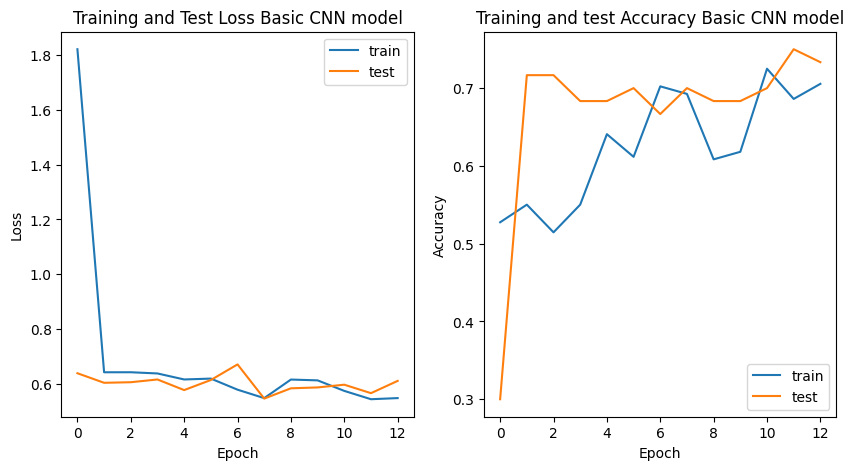

In [ ]:
# Plot the validation and training loss and accuracy values
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(train_val_losses, label='train')
ax[0].plot(test_losses, label='test')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training and Test Loss Basic CNN model')
ax[0].legend()
ax[1].plot(train_val_accuracies, label='train')
ax[1].plot(test_accuracies, label='test')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Training and test Accuracy Basic CNN model')
ax[1].legend()
plt.show()

## Test performance Basic CNN model

In [ ]:
# load in testset
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = ImageFolder(test_path, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

In [ ]:
model.eval()
test_loss = 0.0
y_true = []
y_pred = []
Y_pred_prob = []

with torch.no_grad():
   for i in test_loader:

          #LOAD THE DATA IN A BATCH
          data, target = i

          # moving the tensors to the configured device
          data, target = data.to(DEVICE), target.to(DEVICE)

          target = target.float()
          output = model(data.float())

          loss = criterion(output, target.unsqueeze(1))
          test_loss += loss.item() * data.size(0)


          #PREDICTIONS
          pred_prop = torch.sigmoid(output)
          pred = torch.round(torch.sigmoid(output))

          y_true.extend(target.tolist())
          y_pred.extend(pred.reshape(-1).tolist())
          Y_pred_prob.extend(pred_prop.reshape(-1).tolist())

test_loss /= len(test_loader.sampler)
test_accuracy = accuracy_score(y_true,y_pred)

# get the specificity, sensitivity and g-mean
cm = confusion_matrix(y_true, y_pred)

# Extract the elements of the confusion matrix
tn, fp, fn, tp = cm.ravel()

# Calculate specificity and sensitivity
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

g_mean = imblearn.metrics.geometric_mean_score(y_true, y_pred)


print()
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1score = f1_score(y_true, y_pred)
f1score_macro = f1_score(y_true, y_pred, average = 'macro')
auc_roc = roc_auc_score(y_true, Y_pred_prob)

# Print the evaluation metrics
print('Test_loss:', test_loss)
print('Accuracy:', test_accuracy)
print()

print('Specificity:', specificity)
print('Sensitivity:', sensitivity)
print('g_mean:', g_mean)
print()

print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1score)
print('F1_score_macro:', f1score_macro)
print('AUC-ROC:', auc_roc)
print()

print(classification_report(y_true, y_pred))


Test_loss: 0.6105284015337626
Accuracy: 0.7333333333333333

Specificity: 0.7222222222222222
Sensitivity: 0.7380952380952381
g_mean: 0.7301155956893285

Precision: 0.8611111111111112
Recall: 0.7380952380952381
F1-score: 0.7948717948717949
F1_score_macro: 0.7069597069597069
AUC-ROC: 0.7354497354497354

              precision    recall  f1-score   support

         0.0       0.54      0.72      0.62        18
         1.0       0.86      0.74      0.79        42

    accuracy                           0.73        60
   macro avg       0.70      0.73      0.71        60
weighted avg       0.77      0.73      0.74        60



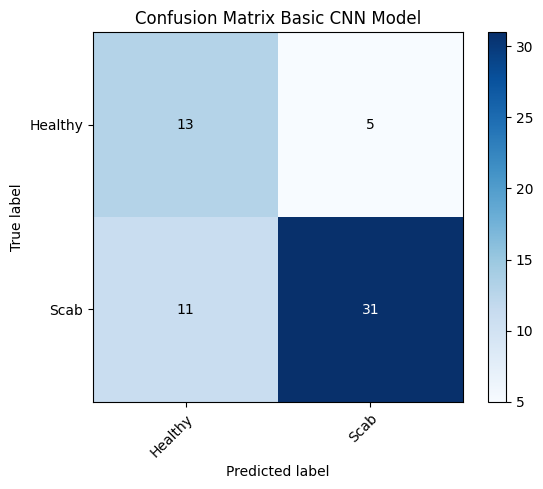

In [ ]:
import matplotlib.pyplot as plt

# Create a confusion matrix:
cm = confusion_matrix(y_true, y_pred)

# Define the class labels
classes = np.unique(['Healthy', 'Scab'])

# Create the plot
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Add axis labels and tick marks
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes,
       yticklabels=classes,
       xlabel='Predicted label',
       ylabel='True label')

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black")

# Add a title and show plot
ax.set_title("Confusion Matrix Basic CNN Model")
plt.show()

# ResNet50 model

In [ ]:
timm.list_models('*resnet50*', pretrained=True) # 'resnet50.a1_in1k', (resnet pretrained on imagenet 1k with input size 224x224)

['cspresnet50.ra_in1k',
 'eca_resnet33ts.ra2_in1k',
 'ecaresnet26t.ra2_in1k',
 'ecaresnet50d.miil_in1k',
 'ecaresnet50d_pruned.miil_in1k',
 'ecaresnet50t.a1_in1k',
 'ecaresnet50t.a2_in1k',
 'ecaresnet50t.a3_in1k',
 'ecaresnet50t.ra2_in1k',
 'ecaresnet101d.miil_in1k',
 'ecaresnet101d_pruned.miil_in1k',
 'ecaresnet269d.ra2_in1k',
 'ecaresnetlight.miil_in1k',
 'gcresnet33ts.ra2_in1k',
 'gcresnet50t.ra2_in1k',
 'inception_resnet_v2.tf_ens_adv_in1k',
 'inception_resnet_v2.tf_in1k',
 'lambda_resnet26rpt_256.c1_in1k',
 'lambda_resnet26t.c1_in1k',
 'lambda_resnet50ts.a1h_in1k',
 'legacy_seresnet18.in1k',
 'legacy_seresnet34.in1k',
 'legacy_seresnet50.in1k',
 'legacy_seresnet101.in1k',
 'legacy_seresnet152.in1k',
 'nf_resnet50.ra2_in1k',
 'resnet10t.c3_in1k',
 'resnet14t.c3_in1k',
 'resnet18.a1_in1k',
 'resnet18.a2_in1k',
 'resnet18.a3_in1k',
 'resnet18.fb_ssl_yfcc100m_ft_in1k',
 'resnet18.fb_swsl_ig1b_ft_in1k',
 'resnet18.gluon_in1k',
 'resnet18.tv_in1k',
 'resnet18d.ra2_in1k',
 'resnet26.bt_i

## Do hyperparameter tuning ResNet50 model

In [ ]:
# Set device and parameters
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCHSIZE = 32
epochs = 100


def define_model(trial):
  model = timm.create_model('resnet50.a1_in1k', pretrained=True, in_chans=3)

  for param in model.parameters():
    param.requires_grad = False

  num_in_features = model.fc.in_features

  head = []
  first_neuron = trial.suggest_categorical('first_neuron', [128, 256, 512, 768])
  head.append(nn.Linear(in_features=num_in_features, out_features=first_neuron))
  head.append(nn.ReLU())
  drop_out = trial.suggest_categorical('drop_out', [0, 0.3, 0.5])
  head.append(nn.Dropout(p=drop_out))
  num_in_features = first_neuron

  head.append(nn.Linear(in_features=num_in_features, out_features=1))

  model.fc = nn.Sequential(*head)

  for param in model.fc.parameters():
    param.requires_grad = True

  return model


def get_dataset():

  transform_train = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

  transform_valid = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])

  train_dataset = ImageFolder(train_path, transform=transform_train)
  val_dataset = ImageFolder(val_path, transform=transform_valid)

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCHSIZE, shuffle=True)
  valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCHSIZE, shuffle=False)

  return train_loader, valid_loader


def objective(trial):

  # Send model to the device
  model = define_model(trial).to(DEVICE)

  # Define optimizer and loss function
  optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "AdamW"])
  learning_rate = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
  weightdecay = trial.suggest_float("weightdecay", low=0.001, high=0.01, log=True)

  if optimizer_name == 'RMSprop':
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weightdecay)
  elif optimizer_name == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weightdecay)
  elif optimizer_name == 'AdamW':
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weightdecay)


  use_pos_weight = trial.suggest_categorical("use_pos_weight", [True, False])

  if use_pos_weight is True:
    criterion = nn.BCEWithLogitsLoss(pos_weight=train_pos_weight_tensor)
  else:
    criterion = nn.BCEWithLogitsLoss()

  # Load in dataset
  train_loader, valid_loader = get_dataset()

  # Initialize variables for early stopping
  best_loss = 1000000
  patience = 5
  no_improvement_count = 0


  # Training
  for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    y_true = []
    y_pred = []


    for i in train_loader:
        #LOADING THE DATA IN A BATCH
        data, target = i

        # moving the tensors to the configured device
        data, target = data.to(DEVICE), target.to(DEVICE)

        #FORWARD PASS
        target = target.float()
        output = model(data.float())
        loss = criterion(output, target.unsqueeze(1))

        train_loss += loss.item() * data.size(0)

        #BACKWARD AND OPTIMIZE
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        #PREDICTIONS BCELogitsloss()
        pred = torch.round(torch.sigmoid(output.detach()))
        y_true.extend(target.tolist())
        y_pred.extend(pred.reshape(-1).tolist())

    train_loss /= len(train_loader.sampler)
    train_accuracy = accuracy_score(y_true, y_pred)

    cm = confusion_matrix(y_true, y_pred)

    # Extract the elements of the confusion matrix
    tn, fp, fn, tp = cm.ravel()

    # Calculate specificity and sensitivity
    train_specificity = tn / (tn + fp)
    train_sensitivity = tp / (tp + fn)

    train_gmean = imblearn.metrics.geometric_mean_score(y_true, y_pred)


    # Evaluation:

    #model in eval mode skips Dropout etc
    model.eval()
    valid_loss = 0.0
    y_true = []
    y_pred = []

    # set the requires_grad flag to false as we are in the test mode
    with torch.no_grad():
        for i in valid_loader:

            #LOAD THE DATA IN A BATCH
            data, target = i

            # moving the tensors to the configured device
            data, target = data.to(DEVICE), target.to(DEVICE)

            target = target.float()
            output = model(data.float())

            loss = criterion(output, target.unsqueeze(1))
            valid_loss += loss.item() * data.size(0)


            #PREDICTIONS
            pred = torch.round(torch.sigmoid(output))
            y_true.extend(target.tolist())
            y_pred.extend(pred.reshape(-1).tolist())

    valid_loss /= len(valid_loader.sampler)
    valid_accuracy = accuracy_score(y_true,y_pred)

    # get the specificity, sensitivity and g-mean
    cm = confusion_matrix(y_true, y_pred)

    # Extract the elements of the confusion matrix
    tn, fp, fn, tp = cm.ravel()

    # Calculate specificity and sensitivity
    valid_specificity = tn / (tn + fp)
    valid_sensitivity = tp / (tp + fn)

    valid_gmean = imblearn.metrics.geometric_mean_score(y_true, y_pred)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}% "
          f"Train specificity: {train_specificity:.4f}, Train sensitivity: {train_sensitivity:.4f} Train g_mean: {train_gmean:.4f}% ----> "
          f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f} %"
          f"Valid specificity: {valid_specificity:.4f}, Valid sensitivity: {valid_sensitivity:.4f} Valid g_mean: {valid_gmean:.4f}")

    # Early stopping
    if valid_loss < best_loss:
        best_loss = valid_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    if no_improvement_count >= patience:
        print("Early stopping criterion met at epoch {}".format(epoch))
        break

    # Pruning
    if trial.should_prune():
        raise optuna.TrialPruned()

    # Report the intermediate result
    trial.report(valid_gmean, epoch)

  return valid_gmean


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=10)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2023-06-13 12:43:14,342] A new study created in memory with name: no-name-4e04ab63-12df-4269-9c16-1d62bfd13a01


Epoch [1/100], Train Loss: 0.6656, Train Accuracy: 0.5517% Train specificity: 0.6667, Train sensitivity: 0.4516 Train g_mean: 0.5487% ----> Valid Loss: 0.5712, Valid Accuracy: 0.6949 %Valid specificity: 0.0000, Valid sensitivity: 1.0000 Valid g_mean: 0.0000
Epoch [2/100], Train Loss: 0.6290, Train Accuracy: 0.6422% Train specificity: 0.4907, Train sensitivity: 0.7742 Train g_mean: 0.6164% ----> Valid Loss: 0.7140, Valid Accuracy: 0.3051 %Valid specificity: 1.0000, Valid sensitivity: 0.0000 Valid g_mean: 0.0000
Epoch [3/100], Train Loss: 0.5085, Train Accuracy: 0.7414% Train specificity: 0.7222, Train sensitivity: 0.7581 Train g_mean: 0.7399% ----> Valid Loss: 0.5346, Valid Accuracy: 0.7458 %Valid specificity: 0.6111, Valid sensitivity: 0.8049 Valid g_mean: 0.7013
Epoch [4/100], Train Loss: 0.4638, Train Accuracy: 0.7716% Train specificity: 0.7685, Train sensitivity: 0.7742 Train g_mean: 0.7714% ----> Valid Loss: 0.5740, Valid Accuracy: 0.6610 %Valid specificity: 0.9444, Valid sensitivi

[I 2023-06-13 13:03:41,190] Trial 0 finished with value: 0.7407971974871922 and parameters: {'first_neuron': 512, 'drop_out': 0, 'optimizer': 'AdamW', 'lr': 0.0036679467603364098, 'weightdecay': 0.006119732815528661, 'use_pos_weight': True}. Best is trial 0 with value: 0.7407971974871922.


Epoch [14/100], Train Loss: 0.2832, Train Accuracy: 0.8922% Train specificity: 0.7870, Train sensitivity: 0.9839 Train g_mean: 0.8800% ----> Valid Loss: 0.4660, Valid Accuracy: 0.7119 %Valid specificity: 0.8333, Valid sensitivity: 0.6585 Valid g_mean: 0.7408
Early stopping criterion met at epoch 13
Epoch [1/100], Train Loss: 0.7219, Train Accuracy: 0.5129% Train specificity: 0.2685, Train sensitivity: 0.7258 Train g_mean: 0.4415% ----> Valid Loss: 0.6636, Valid Accuracy: 0.3051 %Valid specificity: 1.0000, Valid sensitivity: 0.0000 Valid g_mean: 0.0000
Epoch [2/100], Train Loss: 0.6248, Train Accuracy: 0.5819% Train specificity: 0.8519, Train sensitivity: 0.3468 Train g_mean: 0.5435% ----> Valid Loss: 0.6405, Valid Accuracy: 0.3390 %Valid specificity: 0.9444, Valid sensitivity: 0.0732 Valid g_mean: 0.2629
Epoch [3/100], Train Loss: 0.5882, Train Accuracy: 0.7500% Train specificity: 0.6481, Train sensitivity: 0.8387 Train g_mean: 0.7373% ----> Valid Loss: 0.6698, Valid Accuracy: 0.3051 %

[I 2023-06-13 13:23:57,388] Trial 1 finished with value: 0.8198089538832866 and parameters: {'first_neuron': 256, 'drop_out': 0.3, 'optimizer': 'Adam', 'lr': 0.00591142984626744, 'weightdecay': 0.00884812450631272, 'use_pos_weight': True}. Best is trial 1 with value: 0.8198089538832866.


Epoch [14/100], Train Loss: 0.7485, Train Accuracy: 0.6207% Train specificity: 0.6481, Train sensitivity: 0.5968 Train g_mean: 0.6219% ----> Valid Loss: 0.5289, Valid Accuracy: 0.7966 %Valid specificity: 0.8889, Valid sensitivity: 0.7561 Valid g_mean: 0.8198
Early stopping criterion met at epoch 13
Epoch [1/100], Train Loss: 0.6215, Train Accuracy: 0.5862% Train specificity: 0.6574, Train sensitivity: 0.5242 Train g_mean: 0.5870% ----> Valid Loss: 0.7924, Valid Accuracy: 0.3051 %Valid specificity: 1.0000, Valid sensitivity: 0.0000 Valid g_mean: 0.0000
Epoch [2/100], Train Loss: 0.5149, Train Accuracy: 0.7155% Train specificity: 0.7593, Train sensitivity: 0.6774 Train g_mean: 0.7172% ----> Valid Loss: 0.7555, Valid Accuracy: 0.3220 %Valid specificity: 0.9444, Valid sensitivity: 0.0488 Valid g_mean: 0.2146
Epoch [3/100], Train Loss: 0.4039, Train Accuracy: 0.8319% Train specificity: 0.8056, Train sensitivity: 0.8548 Train g_mean: 0.8298% ----> Valid Loss: 0.7159, Valid Accuracy: 0.4068 %

[I 2023-06-13 13:42:05,570] Trial 2 finished with value: 0.7417111980784795 and parameters: {'first_neuron': 512, 'drop_out': 0, 'optimizer': 'Adam', 'lr': 0.0036575113546604395, 'weightdecay': 0.0016212308348748188, 'use_pos_weight': True}. Best is trial 1 with value: 0.8198089538832866.


Epoch [13/100], Train Loss: 0.2605, Train Accuracy: 0.8922% Train specificity: 0.8889, Train sensitivity: 0.8952 Train g_mean: 0.8920% ----> Valid Loss: 0.4868, Valid Accuracy: 0.7288 %Valid specificity: 0.7778, Valid sensitivity: 0.7073 Valid g_mean: 0.7417
Early stopping criterion met at epoch 12
Epoch [1/100], Train Loss: 0.6439, Train Accuracy: 0.4914% Train specificity: 0.9259, Train sensitivity: 0.1129 Train g_mean: 0.3233% ----> Valid Loss: 0.6442, Valid Accuracy: 0.3051 %Valid specificity: 1.0000, Valid sensitivity: 0.0000 Valid g_mean: 0.0000
Epoch [2/100], Train Loss: 0.6375, Train Accuracy: 0.5302% Train specificity: 0.9537, Train sensitivity: 0.1613 Train g_mean: 0.3922% ----> Valid Loss: 0.6449, Valid Accuracy: 0.3051 %Valid specificity: 1.0000, Valid sensitivity: 0.0000 Valid g_mean: 0.0000
Epoch [3/100], Train Loss: 0.6313, Train Accuracy: 0.6336% Train specificity: 0.8889, Train sensitivity: 0.4113 Train g_mean: 0.6046% ----> Valid Loss: 0.6382, Valid Accuracy: 0.3051 %

[I 2023-06-13 14:46:16,472] Trial 3 finished with value: 0.7407971974871922 and parameters: {'first_neuron': 128, 'drop_out': 0, 'optimizer': 'AdamW', 'lr': 0.00011224319456682546, 'weightdecay': 0.00150827563662977, 'use_pos_weight': True}. Best is trial 1 with value: 0.8198089538832866.


Epoch [50/100], Train Loss: 0.3706, Train Accuracy: 0.8707% Train specificity: 0.8241, Train sensitivity: 0.9113 Train g_mean: 0.8666% ----> Valid Loss: 0.5309, Valid Accuracy: 0.7119 %Valid specificity: 0.8333, Valid sensitivity: 0.6585 Valid g_mean: 0.7408
Early stopping criterion met at epoch 49
Epoch [1/100], Train Loss: 0.6568, Train Accuracy: 0.6336% Train specificity: 0.4074, Train sensitivity: 0.8306 Train g_mean: 0.5817% ----> Valid Loss: 0.7922, Valid Accuracy: 0.3051 %Valid specificity: 1.0000, Valid sensitivity: 0.0000 Valid g_mean: 0.0000
Epoch [2/100], Train Loss: 0.5864, Train Accuracy: 0.7155% Train specificity: 0.5648, Train sensitivity: 0.8468 Train g_mean: 0.6916% ----> Valid Loss: 0.6856, Valid Accuracy: 0.5254 %Valid specificity: 0.9444, Valid sensitivity: 0.3415 Valid g_mean: 0.5679
Epoch [3/100], Train Loss: 0.4584, Train Accuracy: 0.8147% Train specificity: 0.7222, Train sensitivity: 0.8952 Train g_mean: 0.8041% ----> Valid Loss: 0.6630, Valid Accuracy: 0.5932 %

[I 2023-06-13 15:00:38,412] Trial 4 finished with value: 0.7128324356402513 and parameters: {'first_neuron': 256, 'drop_out': 0.3, 'optimizer': 'AdamW', 'lr': 0.002595887835668858, 'weightdecay': 0.0032886411414798362, 'use_pos_weight': False}. Best is trial 1 with value: 0.8198089538832866.


Epoch [11/100], Train Loss: 0.2533, Train Accuracy: 0.8966% Train specificity: 0.8796, Train sensitivity: 0.9113 Train g_mean: 0.8953% ----> Valid Loss: 0.5867, Valid Accuracy: 0.6780 %Valid specificity: 0.8333, Valid sensitivity: 0.6098 Valid g_mean: 0.7128
Early stopping criterion met at epoch 10
Epoch [1/100], Train Loss: 0.6126, Train Accuracy: 0.6422% Train specificity: 0.5370, Train sensitivity: 0.7339 Train g_mean: 0.6278% ----> Valid Loss: 0.9208, Valid Accuracy: 0.3051 %Valid specificity: 1.0000, Valid sensitivity: 0.0000 Valid g_mean: 0.0000
Epoch [2/100], Train Loss: 0.4992, Train Accuracy: 0.7198% Train specificity: 0.7685, Train sensitivity: 0.6774 Train g_mean: 0.7215% ----> Valid Loss: 0.7157, Valid Accuracy: 0.4237 %Valid specificity: 0.9444, Valid sensitivity: 0.1951 Valid g_mean: 0.4293
Epoch [3/100], Train Loss: 0.3767, Train Accuracy: 0.8405% Train specificity: 0.8056, Train sensitivity: 0.8710 Train g_mean: 0.8376% ----> Valid Loss: 0.7252, Valid Accuracy: 0.4576 %

[I 2023-06-13 15:07:27,715] Trial 5 pruned. 


Epoch [5/100], Train Loss: 0.3723, Train Accuracy: 0.8190% Train specificity: 0.8241, Train sensitivity: 0.8145 Train g_mean: 0.8193% ----> Valid Loss: 0.6881, Valid Accuracy: 0.5932 %Valid specificity: 0.9444, Valid sensitivity: 0.4390 Valid g_mean: 0.6439
Epoch [1/100], Train Loss: 0.6721, Train Accuracy: 0.5603% Train specificity: 0.7037, Train sensitivity: 0.4355 Train g_mean: 0.5536% ----> Valid Loss: 0.6720, Valid Accuracy: 0.5254 %Valid specificity: 0.7778, Valid sensitivity: 0.4146 Valid g_mean: 0.5679
Epoch [2/100], Train Loss: 0.5936, Train Accuracy: 0.6810% Train specificity: 0.6389, Train sensitivity: 0.7177 Train g_mean: 0.6772% ----> Valid Loss: 0.6809, Valid Accuracy: 0.5254 %Valid specificity: 0.9444, Valid sensitivity: 0.3415 Valid g_mean: 0.5679
Epoch [3/100], Train Loss: 0.4730, Train Accuracy: 0.8017% Train specificity: 0.6481, Train sensitivity: 0.9355 Train g_mean: 0.7787% ----> Valid Loss: 0.7147, Valid Accuracy: 0.4746 %Valid specificity: 0.9444, Valid sensitivi

[I 2023-06-13 15:23:40,310] Trial 6 finished with value: 0.8064778385455118 and parameters: {'first_neuron': 256, 'drop_out': 0.5, 'optimizer': 'Adam', 'lr': 0.0033682488354810814, 'weightdecay': 0.0012301937349481486, 'use_pos_weight': False}. Best is trial 1 with value: 0.8198089538832866.


Epoch [12/100], Train Loss: 0.3620, Train Accuracy: 0.8362% Train specificity: 0.8056, Train sensitivity: 0.8629 Train g_mean: 0.8337% ----> Valid Loss: 0.4960, Valid Accuracy: 0.7797 %Valid specificity: 0.8889, Valid sensitivity: 0.7317 Valid g_mean: 0.8065
Early stopping criterion met at epoch 11
Epoch [1/100], Train Loss: 0.6888, Train Accuracy: 0.5388% Train specificity: 0.0093, Train sensitivity: 1.0000 Train g_mean: 0.0962% ----> Valid Loss: 0.6951, Valid Accuracy: 0.4407 %Valid specificity: 0.9444, Valid sensitivity: 0.2195 Valid g_mean: 0.4553
Epoch [2/100], Train Loss: 0.6494, Train Accuracy: 0.6509% Train specificity: 0.2685, Train sensitivity: 0.9839 Train g_mean: 0.5140% ----> Valid Loss: 0.6703, Valid Accuracy: 0.7119 %Valid specificity: 0.6667, Valid sensitivity: 0.7317 Valid g_mean: 0.6984
Epoch [3/100], Train Loss: 0.6298, Train Accuracy: 0.6293% Train specificity: 0.2130, Train sensitivity: 0.9919 Train g_mean: 0.4596% ----> Valid Loss: 0.6591, Valid Accuracy: 0.7288 %

[I 2023-06-13 15:49:11,218] Trial 7 finished with value: 0.7417111980784795 and parameters: {'first_neuron': 256, 'drop_out': 0, 'optimizer': 'AdamW', 'lr': 0.0005756839817477523, 'weightdecay': 0.005221688120449865, 'use_pos_weight': False}. Best is trial 1 with value: 0.8198089538832866.


Epoch [19/100], Train Loss: 0.2890, Train Accuracy: 0.8836% Train specificity: 0.8426, Train sensitivity: 0.9194 Train g_mean: 0.8801% ----> Valid Loss: 0.5422, Valid Accuracy: 0.7288 %Valid specificity: 0.7778, Valid sensitivity: 0.7073 Valid g_mean: 0.7417
Early stopping criterion met at epoch 18
Epoch [1/100], Train Loss: 0.6389, Train Accuracy: 0.5431% Train specificity: 0.2685, Train sensitivity: 0.7823 Train g_mean: 0.4583% ----> Valid Loss: 0.6505, Valid Accuracy: 0.3051 %Valid specificity: 1.0000, Valid sensitivity: 0.0000 Valid g_mean: 0.0000
Epoch [2/100], Train Loss: 0.6168, Train Accuracy: 0.6379% Train specificity: 0.8704, Train sensitivity: 0.4355 Train g_mean: 0.6157% ----> Valid Loss: 0.6364, Valid Accuracy: 0.3220 %Valid specificity: 0.9444, Valid sensitivity: 0.0488 Valid g_mean: 0.2146


[I 2023-06-13 15:53:10,894] Trial 8 pruned. 


Epoch [3/100], Train Loss: 0.5874, Train Accuracy: 0.7284% Train specificity: 0.6667, Train sensitivity: 0.7823 Train g_mean: 0.7222% ----> Valid Loss: 0.6182, Valid Accuracy: 0.5424 %Valid specificity: 0.8889, Valid sensitivity: 0.3902 Valid g_mean: 0.5890
Epoch [1/100], Train Loss: 0.6902, Train Accuracy: 0.5302% Train specificity: 0.1019, Train sensitivity: 0.9032 Train g_mean: 0.3033% ----> Valid Loss: 0.6908, Valid Accuracy: 0.4915 %Valid specificity: 0.7778, Valid sensitivity: 0.3659 Valid g_mean: 0.5334
Epoch [2/100], Train Loss: 0.6554, Train Accuracy: 0.6897% Train specificity: 0.3611, Train sensitivity: 0.9758 Train g_mean: 0.5936% ----> Valid Loss: 0.6868, Valid Accuracy: 0.5593 %Valid specificity: 0.9444, Valid sensitivity: 0.3902 Valid g_mean: 0.6071
Epoch [3/100], Train Loss: 0.6165, Train Accuracy: 0.7931% Train specificity: 0.6296, Train sensitivity: 0.9355 Train g_mean: 0.7675% ----> Valid Loss: 0.6674, Valid Accuracy: 0.6949 %Valid specificity: 0.8333, Valid sensitivi

[I 2023-06-13 16:26:26,683] Trial 9 finished with value: 0.7791316130543701 and parameters: {'first_neuron': 512, 'drop_out': 0, 'optimizer': 'Adam', 'lr': 0.0004315949691030205, 'weightdecay': 0.004514203459263853, 'use_pos_weight': False}. Best is trial 1 with value: 0.8198089538832866.


Epoch [25/100], Train Loss: 0.2783, Train Accuracy: 0.9052% Train specificity: 0.9074, Train sensitivity: 0.9032 Train g_mean: 0.9053% ----> Valid Loss: 0.5257, Valid Accuracy: 0.7458 %Valid specificity: 0.8889, Valid sensitivity: 0.6829 Valid g_mean: 0.7791
Early stopping criterion met at epoch 24
Study statistics: 
  Number of finished trials:  10
  Number of pruned trials:  2
  Number of complete trials:  8
Best trial:
  Value:  0.8198089538832866
  Params: 
    first_neuron: 256
    drop_out: 0.3
    optimizer: Adam
    lr: 0.00591142984626744
    weightdecay: 0.00884812450631272
    use_pos_weight: True


In [ ]:
trials_df = study.trials_dataframe()
trials_df

,number,value,datetime_start,datetime_complete,duration,params_drop_out,params_first_neuron,params_lr,params_optimizer,params_use_pos_weight,params_weightdecay,state
0,0,0.740797,2023-06-13 12:43:14.346584,2023-06-13 13:03:41.189808,0 days 00:20:26.843224,0.0,512,0.003668,AdamW,True,0.006120,COMPLETE
1,1,0.819809,2023-06-13 13:03:41.192566,2023-06-13 13:23:57.388139,0 days 00:20:16.195573,0.3,256,0.005911,Adam,True,0.008848,COMPLETE
2,2,0.741711,2023-06-13 13:23:57.389832,2023-06-13 13:42:05.569860,0 days 00:18:08.180028,0.0,512,0.003658,Adam,True,0.001621,COMPLETE
3,3,0.740797,2023-06-13 13:42:05.571708,2023-06-13 14:46:16.471866,0 days 01:04:10.900158,0.0,128,0.000112,AdamW,True,0.001508,COMPLETE
4,4,0.712832,2023-06-13 14:46:16.473721,2023-06-13 15:00:38.412343,0 days 00:14:21.938622,0.3,256,0.002596,AdamW,False,0.003289,COMPLETE
5,5,0.517970,2023-06-13 15:00:38.414100,2023-06-13 15:07:27.715270,0 days 00:06:49.301170,0.3,768,0.003994,AdamW,True,0.006034,PRUNED
6,6,0.806478,2023-06-13 15:07:27.716762,2023-06-13 15:23:40.309621,0 days 00:16:12.592859,0.5,256,0.003368,Adam,False,0.001230,COMPLETE
7,7,0.741711,2023-06-13 15:23:40.311192,2023-06-13 15:49:11.217482,0 days 00:25:30.906290,0.0,256,0.000576,AdamW,False,0.005222,COMPLETE
8,8,0.214640,2023-06-13 15:49:11.219198,2023-06-13 15:53:10.894197,0 days 00:03:59.674999,0.5,128,0.000830,AdamW,True,0.003826,PRUNED
9,9,0.779132,2023-06-13 15:53:10.896215,2023-06-13 16:26:26.683150,0 days 00:33:15.786935,0.0,512,0.000432,Adam,False,0.004514,COMPLETE


In [ ]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

## Train the ResNet50 model with the best hyperparameters (on combined training and validation dataset)

In [ ]:
BATCHSIZE = 32
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

best_neurons = 256
best_dropout = 0.3
best_optimizer = 'Adam'
best_lr = 0.005911
epochs = 14
weight_decay = 0.008848
use_pos_weight = False



def define_model():
  model = timm.create_model('resnet50.a1_in1k', pretrained=True, in_chans=3)

  for param in model.parameters():
    param.requires_grad = False


  num_in_features = model.fc.in_features

  head = []
  head.append(nn.Linear(in_features=num_in_features, out_features=best_neurons))
  head.append(nn.ReLU())
  head.append(nn.Dropout(p=best_dropout))
  num_in_features = best_neurons

  head.append(nn.Linear(in_features=num_in_features, out_features=1))

  model.fc = nn.Sequential(*head)

  for param in model.fc.parameters():
    param.requires_grad = True

  return model


def get_dataset():

  transform_train = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

  transform_valid = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])

  train_val_dataset = ImageFolder(train_val_path, transform=transform_train)
  test_dataset = ImageFolder(test_path, transform=transform_valid) # Test dataset only used to see learning curve (no hp tuning)

  train_val_loader = torch.utils.data.DataLoader(train_val_dataset, batch_size=BATCHSIZE, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCHSIZE, shuffle=False)

  return train_val_loader, test_loader


# Send model to the device
model = define_model().to(DEVICE)

# Define optimizer and loss function
if best_optimizer == 'RMSprop':
  optimizer = torch.optim.RMSprop(model.parameters(), lr=best_lr, weight_decay=weight_decay)
elif best_optimizer == 'Adam':
  optimizer = torch.optim.Adam(model.parameters(), lr=best_lr, weight_decay=weight_decay)
elif best_optimizer == 'AdamW':
  optimizer = torch.optim.AdamW(model.parameters(), lr=best_lr, weight_decay=weight_decay)

if use_pos_weight is True:
  criterion = nn.BCEWithLogitsLoss(pos_weight=train_pos_weight_tensor)
else:
  criterion = nn.BCEWithLogitsLoss()

# Load in dataset
train_val_loader, test_loader = get_dataset()

# Initialize variables for early stopping
best_loss = 1000000
patience = 5
no_improvement_count = 0

# train_val
train_val_losses = []
train_val_accuracies = []
test_losses = []
test_accuracies = []

# Training
for epoch in range(epochs):
  model.train()
  train_val_loss = 0.0
  y_true = []
  y_pred = []


  for i in train_val_loader:
      #LOADING THE DATA IN A BATCH
      data, target = i

      # moving the tensors to the configured device
      data, target = data.to(DEVICE), target.to(DEVICE)

      #FORWARD PASS
      target = target.float()
      output = model(data.float())
      loss = criterion(output, target.unsqueeze(1))

      train_val_loss += loss.item() * data.size(0)

      #BACKWARD AND OPTIMIZE
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


      #PREDICTIONS BCELogitsloss()
      pred = torch.round(torch.sigmoid(output.detach()))
      y_true.extend(target.tolist())
      y_pred.extend(pred.reshape(-1).tolist())

  train_val_loss /= len(train_val_loader.sampler)
  train_val_accuracy = accuracy_score(y_true, y_pred)

  train_val_losses.append(train_val_loss)
  train_val_accuracies.append(train_val_accuracy)

  cm = confusion_matrix(y_true, y_pred)

  # Extract the elements of the confusion matrix
  tn, fp, fn, tp = cm.ravel()

  # Calculate specificity and sensitivity
  train_val_specificity = tn / (tn + fp)
  train_val_sensitivity = tp / (tp + fn)

  train_val_gmean = imblearn.metrics.geometric_mean_score(y_true, y_pred)

  # Evaluation:

   #model in eval mode skips Dropout etc
  model.eval()
  test_loss = 0.0
  y_true = []
  y_pred = []

  # set the requires_grad flag to false as we are in the test mode
  with torch.no_grad():
      for i in test_loader:

          #LOAD THE DATA IN A BATCH
          data, target = i

          # moving the tensors to the configured device
          data, target = data.to(DEVICE), target.to(DEVICE)

          target = target.float()
          output = model(data.float())

          loss = criterion(output, target.unsqueeze(1))
          test_loss += loss.item() * data.size(0)


          #PREDICTIONS
          pred = torch.round(torch.sigmoid(output))
          y_true.extend(target.tolist())
          y_pred.extend(pred.reshape(-1).tolist())

  test_loss /= len(test_loader.sampler)
  test_accuracy = accuracy_score(y_true, y_pred)

  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)

  # get the specificity, sensitivity and g-mean
  cm = confusion_matrix(y_true, y_pred)

  # Extract the elements of the confusion matrix
  tn, fp, fn, tp = cm.ravel()

  # Calculate specificity and sensitivity
  test_specificity = tn / (tn + fp)
  test_sensitivity = tp / (tp + fn)

  test_gmean = imblearn.metrics.geometric_mean_score(y_true, y_pred)

  print(f"Epoch [{epoch+1}/{epochs}], Train_val Loss: {train_val_loss:.4f}, Train_val Accuracy: {train_val_accuracy:.4f}%, "
        f"Train_val specificity: {train_val_specificity:.4f}, Train_val sensitivity: {train_val_sensitivity:.4f}, Train_val g_mean: {train_val_gmean:.4f}% ----> "
        f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}%, "
        f"Test specificity: {test_specificity:.4f}, Test sensitivity: {test_sensitivity:.4f}, Test g_mean: {test_gmean:.4f}")

Epoch [1/14], Train_val Loss: 0.7169, Train_val Accuracy: 0.5631%, Train_val specificity: 0.5000, Train_val sensitivity: 0.6182, Train_val g_mean: 0.5560% ----> Test Loss: 0.8127, Test Accuracy: 0.3000%, Test specificity: 1.0000, Test sensitivity: 0.0000, Test g_mean: 0.0000
Epoch [2/14], Train_val Loss: 0.6270, Train_val Accuracy: 0.6990%, Train_val specificity: 0.6597, Train_val sensitivity: 0.7333, Train_val g_mean: 0.6956% ----> Test Loss: 0.6385, Test Accuracy: 0.7000%, Test specificity: 0.8333, Test sensitivity: 0.6429, Test g_mean: 0.7319
Epoch [3/14], Train_val Loss: 0.5590, Train_val Accuracy: 0.7508%, Train_val specificity: 0.6528, Train_val sensitivity: 0.8364, Train_val g_mean: 0.7389% ----> Test Loss: 0.5808, Test Accuracy: 0.7667%, Test specificity: 0.8333, Test sensitivity: 0.7381, Test g_mean: 0.7843
Epoch [4/14], Train_val Loss: 0.5902, Train_val Accuracy: 0.6796%, Train_val specificity: 0.6181, Train_val sensitivity: 0.7333, Train_val g_mean: 0.6732% ----> Test Loss: 

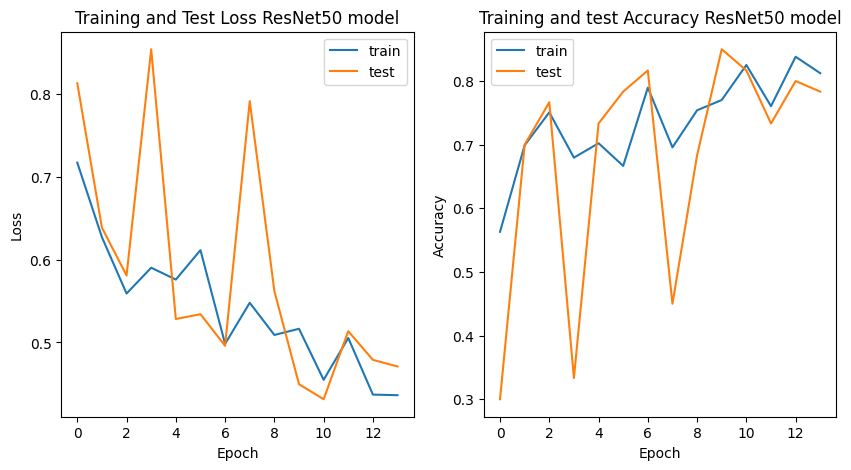

In [ ]:
# Plot the validation and training loss and accuracy values
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(train_val_losses, label='train')
ax[0].plot(test_losses, label='test')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training and Test Loss ResNet50 model')
ax[0].legend()
ax[1].plot(train_val_accuracies, label='train')
ax[1].plot(test_accuracies, label='test')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Training and test Accuracy ResNet50 model')
ax[1].legend()
plt.show()

## Test performance ResNet50 model

In [ ]:
# load in testset
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = ImageFolder(test_path, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

In [ ]:
model.eval()
test_loss = 0.0
y_true = []
y_pred = []
Y_pred_prob = []

with torch.no_grad():
   for i in test_loader:

          #LOAD THE DATA IN A BATCH
          data, target = i

          # moving the tensors to the configured device
          data, target = data.to(DEVICE), target.to(DEVICE)

          target = target.float()
          output = model(data.float())

          loss = criterion(output, target.unsqueeze(1))
          test_loss += loss.item() * data.size(0)


          #PREDICTIONS
          pred_prop = torch.sigmoid(output)
          pred = torch.round(torch.sigmoid(output))

          y_true.extend(target.tolist())
          y_pred.extend(pred.reshape(-1).tolist())
          Y_pred_prob.extend(pred_prop.reshape(-1).tolist())

test_loss /= len(test_loader.sampler)
test_accuracy = accuracy_score(y_true,y_pred)

# get the specificity, sensitivity and g-mean
cm = confusion_matrix(y_true, y_pred)

# Extract the elements of the confusion matrix
tn, fp, fn, tp = cm.ravel()

# Calculate specificity and sensitivity
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

g_mean = imblearn.metrics.geometric_mean_score(y_true, y_pred)


print()
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1score = f1_score(y_true, y_pred)
f1score_macro = f1_score(y_true, y_pred, average = 'macro')
auc_roc = roc_auc_score(y_true, Y_pred_prob)

# Print the evaluation metrics
print('Test_loss:', test_loss)
print('Accuracy:', test_accuracy)
print()

print('Specificity:', specificity)
print('Sensitivity:', sensitivity)
print('g_mean:', g_mean)
print()

print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1score)
print('F1_score_macro:', f1score_macro)
print('AUC-ROC:', auc_roc)
print()

print(classification_report(y_true, y_pred))


Test_loss: 0.47102678219477334
Accuracy: 0.7833333333333333

Specificity: 0.8888888888888888
Sensitivity: 0.7380952380952381
g_mean: 0.8099905283919412

Precision: 0.9393939393939394
Recall: 0.7380952380952381
F1-score: 0.8266666666666667
F1_score_macro: 0.7688888888888888
AUC-ROC: 0.9113756613756614

              precision    recall  f1-score   support

         0.0       0.59      0.89      0.71        18
         1.0       0.94      0.74      0.83        42

    accuracy                           0.78        60
   macro avg       0.77      0.81      0.77        60
weighted avg       0.84      0.78      0.79        60



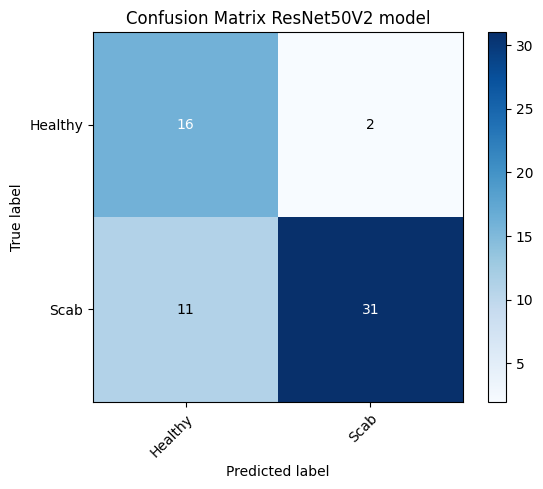

In [ ]:
import matplotlib.pyplot as plt

# Create a confusion matrix:
cm = confusion_matrix(y_true, y_pred)

# Define the class labels
classes = np.unique(['Healthy', 'Scab'])

# Create the plot
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Add axis labels and tick marks
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes,
       yticklabels=classes,
       xlabel='Predicted label',
       ylabel='True label')

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black")

# Add a title and show plot
ax.set_title("Confusion Matrix ResNet50V2 model")
plt.show()

# EfficientNetV2B0 model

In [ ]:
timm.list_models('*efficientnetv2_b0*', pretrained=True)
# 'tf_efficientnetv2_b0.in1k' (fficientnetv2 pretrained on imagenet 1k with input size 224x224)

['tf_efficientnetv2_b0.in1k']

## Do hyperparameter tuning EfficientNetV2B0 model

In [ ]:
# Set device and parameters
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCHSIZE = 32
epochs = 100


def define_model(trial):
  model = timm.create_model('tf_efficientnetv2_b0.in1k', pretrained=True, in_chans=3)

  for param in model.parameters():
    param.requires_grad = False

  num_in_features = model.get_classifier().in_features

  head = []
  first_neuron = trial.suggest_categorical('first_neuron', [128, 256, 512, 768])
  head.append(nn.Linear(in_features=num_in_features, out_features=first_neuron))
  head.append(nn.ReLU())
  drop_out = trial.suggest_categorical('drop_out', [0, 0.3, 0.5])
  head.append(nn.Dropout(p=drop_out))
  num_in_features = first_neuron

  head.append(nn.Linear(in_features=num_in_features, out_features=1))

  model.classifier = nn.Sequential(*head)

  for param in model.classifier.parameters():
    param.requires_grad = True

  return model


def get_dataset():

  transform_train = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

  transform_valid = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])

  train_dataset = ImageFolder(train_path, transform=transform_train)
  val_dataset = ImageFolder(val_path, transform=transform_valid)

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCHSIZE, shuffle=True)
  valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCHSIZE, shuffle=True)

  return train_loader, valid_loader


def objective(trial):

  # Send model to the device
  model = define_model(trial).to(DEVICE)

  # Define optimizer and loss function
  optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "AdamW"])
  learning_rate = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
  weightdecay = trial.suggest_float("weightdecay", low=0.001, high=0.01, log=True)

  if optimizer_name == 'RMSprop':
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weightdecay)
  elif optimizer_name == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weightdecay)
  elif optimizer_name == 'AdamW':
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weightdecay)


  use_pos_weight = trial.suggest_categorical("use_pos_weight", [True, False])

  if use_pos_weight is True:
    criterion = nn.BCEWithLogitsLoss(pos_weight=train_pos_weight_tensor)
  else:
    criterion = nn.BCEWithLogitsLoss()

  # Load in dataset
  train_loader, valid_loader = get_dataset()

  # Initialize variables for early stopping
  best_loss = 1000000
  patience = 5
  no_improvement_count = 0


  # Training
  for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    y_true = []
    y_pred = []


    for i in train_loader:
        #LOADING THE DATA IN A BATCH
        data, target = i

        # moving the tensors to the configured device
        data, target = data.to(DEVICE), target.to(DEVICE)

        #FORWARD PASS
        target = target.float()
        output = model(data.float())
        loss = criterion(output, target.unsqueeze(1))

        train_loss += loss.item() * data.size(0)

        #BACKWARD AND OPTIMIZE
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        #PREDICTIONS BCELogitsloss()
        pred = torch.round(torch.sigmoid(output.detach()))
        y_true.extend(target.tolist())
        y_pred.extend(pred.reshape(-1).tolist())

    train_loss /= len(train_loader.sampler)
    train_accuracy = accuracy_score(y_true, y_pred)

    cm = confusion_matrix(y_true, y_pred)

    # Extract the elements of the confusion matrix
    tn, fp, fn, tp = cm.ravel()

    # Calculate specificity and sensitivity
    train_specificity = tn / (tn + fp)
    train_sensitivity = tp / (tp + fn)

    train_gmean = imblearn.metrics.geometric_mean_score(y_true, y_pred)


    # Evaluation:

    #model in eval mode skips Dropout etc
    model.eval()
    valid_loss = 0.0
    y_true = []
    y_pred = []

    # set the requires_grad flag to false as we are in the test mode
    with torch.no_grad():
        for i in valid_loader:

            #LOAD THE DATA IN A BATCH
            data, target = i

            # moving the tensors to the configured device
            data, target = data.to(DEVICE), target.to(DEVICE)

            target = target.float()
            output = model(data.float())

            loss = criterion(output, target.unsqueeze(1))
            valid_loss += loss.item() * data.size(0)


            #PREDICTIONS
            pred = torch.round(torch.sigmoid(output))
            y_true.extend(target.tolist())
            y_pred.extend(pred.reshape(-1).tolist())

    valid_loss /= len(valid_loader.sampler)
    valid_accuracy = accuracy_score(y_true,y_pred)

    # get the specificity, sensitivity and g-mean
    cm = confusion_matrix(y_true, y_pred)

    # Extract the elements of the confusion matrix
    tn, fp, fn, tp = cm.ravel()

    # Calculate specificity and sensitivity
    valid_specificity = tn / (tn + fp)
    valid_sensitivity = tp / (tp + fn)

    valid_gmean = imblearn.metrics.geometric_mean_score(y_true, y_pred)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}% "
          f"Train specificity: {train_specificity:.4f}, Train sensitivity: {train_sensitivity:.4f} Train g_mean: {train_gmean:.4f}% ----> "
          f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}% "
          f"Valid specificity: {valid_specificity:.4f}, Valid sensitivity: {valid_sensitivity:.4f} Valid g_mean: {valid_gmean:.4f}")

    # Early stopping
    if valid_loss < best_loss:
        best_loss = valid_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    if no_improvement_count >= patience:
        print("Early stopping criterion met at epoch {}".format(epoch))
        break

    # Pruning
    if trial.should_prune():
        raise optuna.TrialPruned()

    # Report the intermediate result
    trial.report(valid_gmean, epoch)

  return valid_gmean


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=10)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2023-06-13 17:23:14,547] A new study created in memory with name: no-name-5e374713-c7a4-4dd2-beab-3cdc953b15c4


Epoch [1/100], Train Loss: 0.5822, Train Accuracy: 0.6810% Train specificity: 0.5833, Train sensitivity: 0.7661 Train g_mean: 0.6685% ----> Valid Loss: 0.5333, Valid Accuracy: 0.7119% Valid specificity: 0.8889, Valid sensitivity: 0.6341 Valid g_mean: 0.7508
Epoch [2/100], Train Loss: 0.3086, Train Accuracy: 0.8578% Train specificity: 0.8519, Train sensitivity: 0.8629 Train g_mean: 0.8574% ----> Valid Loss: 0.4375, Valid Accuracy: 0.7797% Valid specificity: 0.8889, Valid sensitivity: 0.7317 Valid g_mean: 0.8065
Epoch [3/100], Train Loss: 0.2646, Train Accuracy: 0.8966% Train specificity: 0.8704, Train sensitivity: 0.9194 Train g_mean: 0.8945% ----> Valid Loss: 0.3703, Valid Accuracy: 0.7797% Valid specificity: 0.6111, Valid sensitivity: 0.8537 Valid g_mean: 0.7223
Epoch [4/100], Train Loss: 0.2287, Train Accuracy: 0.9095% Train specificity: 0.9167, Train sensitivity: 0.9032 Train g_mean: 0.9099% ----> Valid Loss: 0.5830, Valid Accuracy: 0.7797% Valid specificity: 0.2778, Valid sensitivi

[I 2023-06-13 17:52:24,055] Trial 0 finished with value: 0.7650920556760059 and parameters: {'first_neuron': 128, 'drop_out': 0.3, 'optimizer': 'RMSprop', 'lr': 0.001812451120512392, 'weightdecay': 0.0026889012836393577, 'use_pos_weight': True}. Best is trial 0 with value: 0.7650920556760059.


Epoch [22/100], Train Loss: 0.1388, Train Accuracy: 0.9440% Train specificity: 0.9352, Train sensitivity: 0.9516 Train g_mean: 0.9434% ----> Valid Loss: 0.3828, Valid Accuracy: 0.8136% Valid specificity: 0.6667, Valid sensitivity: 0.8780 Valid g_mean: 0.7651
Early stopping criterion met at epoch 21
Epoch [1/100], Train Loss: 0.5146, Train Accuracy: 0.7543% Train specificity: 0.6574, Train sensitivity: 0.8387 Train g_mean: 0.7425% ----> Valid Loss: 0.4733, Valid Accuracy: 0.8305% Valid specificity: 0.6667, Valid sensitivity: 0.9024 Valid g_mean: 0.7756
Epoch [2/100], Train Loss: 0.3721, Train Accuracy: 0.8621% Train specificity: 0.8519, Train sensitivity: 0.8710 Train g_mean: 0.8614% ----> Valid Loss: 0.4556, Valid Accuracy: 0.7966% Valid specificity: 0.8333, Valid sensitivity: 0.7805 Valid g_mean: 0.8065
Epoch [3/100], Train Loss: 0.2988, Train Accuracy: 0.8836% Train specificity: 0.8889, Train sensitivity: 0.8790 Train g_mean: 0.8839% ----> Valid Loss: 0.4010, Valid Accuracy: 0.8305% 

[I 2023-06-13 18:18:52,156] Trial 1 finished with value: 0.7175689158899586 and parameters: {'first_neuron': 128, 'drop_out': 0.5, 'optimizer': 'RMSprop', 'lr': 0.0005298360493778486, 'weightdecay': 0.002839754214200608, 'use_pos_weight': True}. Best is trial 0 with value: 0.7650920556760059.


Epoch [19/100], Train Loss: 0.1663, Train Accuracy: 0.9397% Train specificity: 0.9352, Train sensitivity: 0.9435 Train g_mean: 0.9394% ----> Valid Loss: 0.3898, Valid Accuracy: 0.8136% Valid specificity: 0.5556, Valid sensitivity: 0.9268 Valid g_mean: 0.7176
Early stopping criterion met at epoch 18
Epoch [1/100], Train Loss: 0.6548, Train Accuracy: 0.6379% Train specificity: 0.8981, Train sensitivity: 0.4113 Train g_mean: 0.6078% ----> Valid Loss: 0.6269, Valid Accuracy: 0.6441% Valid specificity: 0.5556, Valid sensitivity: 0.6829 Valid g_mean: 0.6160
Epoch [2/100], Train Loss: 0.5004, Train Accuracy: 0.8578% Train specificity: 0.7500, Train sensitivity: 0.9516 Train g_mean: 0.8448% ----> Valid Loss: 0.5152, Valid Accuracy: 0.7797% Valid specificity: 0.5556, Valid sensitivity: 0.8780 Valid g_mean: 0.6984
Epoch [3/100], Train Loss: 0.3976, Train Accuracy: 0.8664% Train specificity: 0.8796, Train sensitivity: 0.8548 Train g_mean: 0.8671% ----> Valid Loss: 0.4827, Valid Accuracy: 0.7797% 

[I 2023-06-13 18:41:26,505] Trial 2 finished with value: 0.7325198740332296 and parameters: {'first_neuron': 128, 'drop_out': 0.3, 'optimizer': 'Adam', 'lr': 0.001007911413036518, 'weightdecay': 0.0012310159671180643, 'use_pos_weight': False}. Best is trial 0 with value: 0.7650920556760059.


Epoch [16/100], Train Loss: 0.1233, Train Accuracy: 0.9526% Train specificity: 0.9352, Train sensitivity: 0.9677 Train g_mean: 0.9513% ----> Valid Loss: 0.4208, Valid Accuracy: 0.7966% Valid specificity: 0.6111, Valid sensitivity: 0.8780 Valid g_mean: 0.7325
Early stopping criterion met at epoch 15
Epoch [1/100], Train Loss: 0.6879, Train Accuracy: 0.5560% Train specificity: 0.1204, Train sensitivity: 0.9355 Train g_mean: 0.3356% ----> Valid Loss: 0.6666, Valid Accuracy: 0.6949% Valid specificity: 0.0000, Valid sensitivity: 1.0000 Valid g_mean: 0.0000
Epoch [2/100], Train Loss: 0.6687, Train Accuracy: 0.6466% Train specificity: 0.3148, Train sensitivity: 0.9355 Train g_mean: 0.5427% ----> Valid Loss: 0.6555, Valid Accuracy: 0.7797% Valid specificity: 0.2778, Valid sensitivity: 1.0000 Valid g_mean: 0.5270
Epoch [3/100], Train Loss: 0.6481, Train Accuracy: 0.7629% Train specificity: 0.5000, Train sensitivity: 0.9919 Train g_mean: 0.7042% ----> Valid Loss: 0.6498, Valid Accuracy: 0.8305% 

[I 2023-06-13 19:38:53,043] Trial 3 finished with value: 0.7222743362477778 and parameters: {'first_neuron': 128, 'drop_out': 0.5, 'optimizer': 'Adam', 'lr': 0.00016052457434680227, 'weightdecay': 0.007109786483741661, 'use_pos_weight': False}. Best is trial 0 with value: 0.7650920556760059.


Epoch [41/100], Train Loss: 0.2640, Train Accuracy: 0.9310% Train specificity: 0.9167, Train sensitivity: 0.9435 Train g_mean: 0.9300% ----> Valid Loss: 0.4449, Valid Accuracy: 0.7797% Valid specificity: 0.6111, Valid sensitivity: 0.8537 Valid g_mean: 0.7223
Early stopping criterion met at epoch 40
Epoch [1/100], Train Loss: 0.5889, Train Accuracy: 0.6897% Train specificity: 0.5185, Train sensitivity: 0.8387 Train g_mean: 0.6595% ----> Valid Loss: 0.6004, Valid Accuracy: 0.6949% Valid specificity: 0.8333, Valid sensitivity: 0.6341 Valid g_mean: 0.7269
Epoch [2/100], Train Loss: 0.3605, Train Accuracy: 0.8664% Train specificity: 0.8704, Train sensitivity: 0.8629 Train g_mean: 0.8666% ----> Valid Loss: 0.4284, Valid Accuracy: 0.8136% Valid specificity: 0.6667, Valid sensitivity: 0.8780 Valid g_mean: 0.7651
Epoch [3/100], Train Loss: 0.2857, Train Accuracy: 0.9009% Train specificity: 0.8796, Train sensitivity: 0.9194 Train g_mean: 0.8993% ----> Valid Loss: 0.4420, Valid Accuracy: 0.7627% 

[I 2023-06-13 19:55:46,592] Trial 4 finished with value: 0.7453559924999299 and parameters: {'first_neuron': 256, 'drop_out': 0.3, 'optimizer': 'Adam', 'lr': 0.0022704910957137944, 'weightdecay': 0.008750724790490681, 'use_pos_weight': False}. Best is trial 0 with value: 0.7650920556760059.


Epoch [12/100], Train Loss: 0.2016, Train Accuracy: 0.9267% Train specificity: 0.9444, Train sensitivity: 0.9113 Train g_mean: 0.9277% ----> Valid Loss: 0.4245, Valid Accuracy: 0.8644% Valid specificity: 0.5556, Valid sensitivity: 1.0000 Valid g_mean: 0.7454
Early stopping criterion met at epoch 11
Epoch [1/100], Train Loss: 0.8113, Train Accuracy: 0.6293% Train specificity: 0.5556, Train sensitivity: 0.6935 Train g_mean: 0.6207% ----> Valid Loss: 0.5985, Valid Accuracy: 0.6610% Valid specificity: 0.8889, Valid sensitivity: 0.5610 Valid g_mean: 0.7061


[I 2023-06-13 19:58:35,981] Trial 5 pruned. 


Epoch [2/100], Train Loss: 0.3585, Train Accuracy: 0.8405% Train specificity: 0.8704, Train sensitivity: 0.8145 Train g_mean: 0.8420% ----> Valid Loss: 0.4429, Valid Accuracy: 0.7966% Valid specificity: 0.5556, Valid sensitivity: 0.9024 Valid g_mean: 0.7081
Epoch [1/100], Train Loss: 0.4414, Train Accuracy: 0.7802% Train specificity: 0.7500, Train sensitivity: 0.8065 Train g_mean: 0.7777% ----> Valid Loss: 0.5215, Valid Accuracy: 0.7288% Valid specificity: 0.8333, Valid sensitivity: 0.6829 Valid g_mean: 0.7544
Epoch [2/100], Train Loss: 0.2019, Train Accuracy: 0.9267% Train specificity: 0.9074, Train sensitivity: 0.9435 Train g_mean: 0.9253% ----> Valid Loss: 0.5758, Valid Accuracy: 0.7119% Valid specificity: 0.9444, Valid sensitivity: 0.6098 Valid g_mean: 0.7589


[I 2023-06-13 20:02:52,687] Trial 6 pruned. 


Epoch [3/100], Train Loss: 0.2468, Train Accuracy: 0.8922% Train specificity: 0.9352, Train sensitivity: 0.8548 Train g_mean: 0.8941% ----> Valid Loss: 0.5308, Valid Accuracy: 0.8305% Valid specificity: 0.5000, Valid sensitivity: 0.9756 Valid g_mean: 0.6984
Epoch [1/100], Train Loss: 0.4299, Train Accuracy: 0.7543% Train specificity: 0.8056, Train sensitivity: 0.7097 Train g_mean: 0.7561% ----> Valid Loss: 0.3989, Valid Accuracy: 0.8136% Valid specificity: 0.7222, Valid sensitivity: 0.8537 Valid g_mean: 0.7852
Epoch [2/100], Train Loss: 0.2850, Train Accuracy: 0.9052% Train specificity: 0.8981, Train sensitivity: 0.9113 Train g_mean: 0.9047% ----> Valid Loss: 0.4578, Valid Accuracy: 0.8305% Valid specificity: 0.8889, Valid sensitivity: 0.8049 Valid g_mean: 0.8458
Epoch [3/100], Train Loss: 0.1832, Train Accuracy: 0.9224% Train specificity: 0.8889, Train sensitivity: 0.9516 Train g_mean: 0.9197% ----> Valid Loss: 0.3819, Valid Accuracy: 0.7627% Valid specificity: 0.7778, Valid sensitivi

[I 2023-06-13 20:18:24,110] Trial 7 finished with value: 0.7426240737446834 and parameters: {'first_neuron': 128, 'drop_out': 0, 'optimizer': 'Adam', 'lr': 0.006555758799706216, 'weightdecay': 0.001016632465704505, 'use_pos_weight': True}. Best is trial 0 with value: 0.7650920556760059.


Epoch [11/100], Train Loss: 0.1041, Train Accuracy: 0.9526% Train specificity: 0.9259, Train sensitivity: 0.9758 Train g_mean: 0.9505% ----> Valid Loss: 0.3676, Valid Accuracy: 0.8136% Valid specificity: 0.6111, Valid sensitivity: 0.9024 Valid g_mean: 0.7426
Early stopping criterion met at epoch 10
Epoch [1/100], Train Loss: 0.5074, Train Accuracy: 0.8017% Train specificity: 0.8796, Train sensitivity: 0.7339 Train g_mean: 0.8035% ----> Valid Loss: 0.4747, Valid Accuracy: 0.7458% Valid specificity: 0.5000, Valid sensitivity: 0.8537 Valid g_mean: 0.6533


[I 2023-06-13 20:21:16,132] Trial 8 pruned. 


Epoch [2/100], Train Loss: 0.3516, Train Accuracy: 0.8793% Train specificity: 0.8333, Train sensitivity: 0.9194 Train g_mean: 0.8753% ----> Valid Loss: 0.4170, Valid Accuracy: 0.8136% Valid specificity: 0.6667, Valid sensitivity: 0.8780 Valid g_mean: 0.7651
Epoch [1/100], Train Loss: 0.5542, Train Accuracy: 0.7112% Train specificity: 0.6574, Train sensitivity: 0.7581 Train g_mean: 0.7059% ----> Valid Loss: 0.5316, Valid Accuracy: 0.7797% Valid specificity: 0.3333, Valid sensitivity: 0.9756 Valid g_mean: 0.5703


[I 2023-06-13 20:24:03,805] Trial 9 pruned. 


Epoch [2/100], Train Loss: 0.3866, Train Accuracy: 0.8707% Train specificity: 0.7778, Train sensitivity: 0.9516 Train g_mean: 0.8603% ----> Valid Loss: 0.4872, Valid Accuracy: 0.7627% Valid specificity: 0.7778, Valid sensitivity: 0.7561 Valid g_mean: 0.7669
Study statistics: 
  Number of finished trials:  10
  Number of pruned trials:  4
  Number of complete trials:  6
Best trial:
  Value:  0.7650920556760059
  Params: 
    first_neuron: 128
    drop_out: 0.3
    optimizer: RMSprop
    lr: 0.001812451120512392
    weightdecay: 0.0026889012836393577
    use_pos_weight: True


In [ ]:
trials_df = study.trials_dataframe()
trials_df

,number,value,datetime_start,datetime_complete,duration,params_drop_out,params_first_neuron,params_lr,params_optimizer,params_use_pos_weight,params_weightdecay,state
0,0,0.765092,2023-06-13 17:23:14.549524,2023-06-13 17:52:24.055450,0 days 00:29:09.505926,0.3,128,0.001812,RMSprop,True,0.002689,COMPLETE
1,1,0.717569,2023-06-13 17:52:24.057954,2023-06-13 18:18:52.156359,0 days 00:26:28.098405,0.5,128,0.000530,RMSprop,True,0.002840,COMPLETE
2,2,0.732520,2023-06-13 18:18:52.157962,2023-06-13 18:41:26.505003,0 days 00:22:34.347041,0.3,128,0.001008,Adam,False,0.001231,COMPLETE
3,3,0.722274,2023-06-13 18:41:26.506843,2023-06-13 19:38:53.042483,0 days 00:57:26.535640,0.5,128,0.000161,Adam,False,0.007110,COMPLETE
4,4,0.745356,2023-06-13 19:38:53.045505,2023-06-13 19:55:46.591948,0 days 00:16:53.546443,0.3,256,0.002270,Adam,False,0.008751,COMPLETE
5,5,0.706148,2023-06-13 19:55:46.598687,2023-06-13 19:58:35.981777,0 days 00:02:49.383090,0.0,768,0.001065,RMSprop,False,0.003689,PRUNED
6,6,0.758868,2023-06-13 19:58:35.983415,2023-06-13 20:02:52.686823,0 days 00:04:16.703408,0.0,512,0.008352,Adam,True,0.003427,PRUNED
7,7,0.742624,2023-06-13 20:02:52.692800,2023-06-13 20:18:24.109773,0 days 00:15:31.416973,0.0,128,0.006556,Adam,True,0.001017,COMPLETE
8,8,0.653322,2023-06-13 20:18:24.111743,2023-06-13 20:21:16.132275,0 days 00:02:52.020532,0.3,512,0.001770,Adam,False,0.003082,PRUNED
9,9,0.570266,2023-06-13 20:21:16.135665,2023-06-13 20:24:03.805378,0 days 00:02:47.669713,0.5,768,0.004430,AdamW,False,0.001379,PRUNED


In [ ]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

## Train the EfficientNetV2B0 model with the best hyperparameters (on combined training and validation dataset)

In [ ]:
BATCHSIZE = 32
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

best_neurons = 128
best_dropout = 0.3
best_optimizer = 'RMSprop'
best_lr = 0.001812
epochs = 22
weight_decay = 0.002689
use_pos_weight = True


def define_model():
  model = timm.create_model('tf_efficientnetv2_b0.in1k', pretrained=True, in_chans=3)

  for param in model.parameters():
    param.requires_grad = False

  num_in_features = model.get_classifier().in_features

  head = []
  head.append(nn.Linear(in_features=num_in_features, out_features=best_neurons))
  head.append(nn.ReLU())
  head.append(nn.Dropout(p=best_dropout))
  num_in_features = best_neurons

  head.append(nn.Linear(in_features=num_in_features, out_features=1))

  model.classifier = nn.Sequential(*head)

  for param in model.classifier.parameters():
    param.requires_grad = True

  return model


def get_dataset():

  transform_train = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

  transform_valid = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])

  train_val_dataset = ImageFolder(train_val_path, transform=transform_train)
  test_dataset = ImageFolder(test_path, transform=transform_valid) # Test dataset only used to see learning curve (no hp tuning)

  train_val_loader = torch.utils.data.DataLoader(train_val_dataset, batch_size=BATCHSIZE, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCHSIZE, shuffle=False)

  return train_val_loader, test_loader


# Send model to the device
model = define_model().to(DEVICE)

# Define optimizer and loss function
if best_optimizer == 'RMSprop':
  optimizer = torch.optim.RMSprop(model.parameters(), lr=best_lr, weight_decay=weight_decay)
elif best_optimizer == 'Adam':
  optimizer = torch.optim.Adam(model.parameters(), lr=best_lr, weight_decay=weight_decay)
elif best_optimizer == 'AdamW':
  optimizer = torch.optim.AdamW(model.parameters(), lr=best_lr, weight_decay=weight_decay)

if use_pos_weight is True:
  criterion = nn.BCEWithLogitsLoss(pos_weight=train_pos_weight_tensor)
else:
  criterion = nn.BCEWithLogitsLoss()

# Load in dataset
train_val_loader, test_loader = get_dataset()

# Initialize variables for early stopping
best_loss = 1000000
patience = 5
no_improvement_count = 0

# train_val
train_val_losses = []
train_val_accuracies = []
test_losses = []
test_accuracies = []

# Training
for epoch in range(epochs):
  model.train()
  train_val_loss = 0.0
  y_true = []
  y_pred = []


  for i in train_val_loader:
      #LOADING THE DATA IN A BATCH
      data, target = i

      # moving the tensors to the configured device
      data, target = data.to(DEVICE), target.to(DEVICE)

      #FORWARD PASS
      target = target.float()
      output = model(data.float())
      loss = criterion(output, target.unsqueeze(1))

      train_val_loss += loss.item() * data.size(0)

      #BACKWARD AND OPTIMIZE
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


      #PREDICTIONS BCELogitsloss()
      pred = torch.round(torch.sigmoid(output.detach()))
      y_true.extend(target.tolist())
      y_pred.extend(pred.reshape(-1).tolist())

  train_val_loss /= len(train_val_loader.sampler)
  train_val_accuracy = accuracy_score(y_true, y_pred)

  train_val_losses.append(train_val_loss)
  train_val_accuracies.append(train_val_accuracy)

  cm = confusion_matrix(y_true, y_pred)

  # Extract the elements of the confusion matrix
  tn, fp, fn, tp = cm.ravel()

  # Calculate specificity and sensitivity
  train_val_specificity = tn / (tn + fp)
  train_val_sensitivity = tp / (tp + fn)

  train_val_gmean = imblearn.metrics.geometric_mean_score(y_true, y_pred)

  # Evaluation:

   #model in eval mode skips Dropout etc
  model.eval()
  test_loss = 0.0
  y_true = []
  y_pred = []

  # set the requires_grad flag to false as we are in the test mode
  with torch.no_grad():
      for i in test_loader:

          #LOAD THE DATA IN A BATCH
          data, target = i

          # moving the tensors to the configured device
          data, target = data.to(DEVICE), target.to(DEVICE)

          target = target.float()
          output = model(data.float())

          loss = criterion(output, target.unsqueeze(1))
          test_loss += loss.item() * data.size(0)


          #PREDICTIONS
          pred = torch.round(torch.sigmoid(output))
          y_true.extend(target.tolist())
          y_pred.extend(pred.reshape(-1).tolist())

  test_loss /= len(test_loader.sampler)
  test_accuracy = accuracy_score(y_true, y_pred)

  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)

  # get the specificity, sensitivity and g-mean
  cm = confusion_matrix(y_true, y_pred)

  # Extract the elements of the confusion matrix
  tn, fp, fn, tp = cm.ravel()

  # Calculate specificity and sensitivity
  test_specificity = tn / (tn + fp)
  test_sensitivity = tp / (tp + fn)

  test_gmean = imblearn.metrics.geometric_mean_score(y_true, y_pred)

  print(f"Epoch [{epoch+1}/{epochs}], Train_val Loss: {train_val_loss:.4f}, Train_val Accuracy: {train_val_accuracy:.4f}%, "
        f"Train_val specificity: {train_val_specificity:.4f}, Train_val sensitivity: {train_val_sensitivity:.4f}, Train_val g_mean: {train_val_gmean:.4f}% ----> "
        f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}%, "
        f"Test specificity: {test_specificity:.4f}, Test sensitivity: {test_sensitivity:.4f}, Test g_mean: {test_gmean:.4f}")

Epoch [1/22], Train_val Loss: 0.5749, Train_val Accuracy: 0.7055%, Train_val specificity: 0.6528, Train_val sensitivity: 0.7515, Train_val g_mean: 0.7004% ----> Test Loss: 0.3800, Test Accuracy: 0.7667%, Test specificity: 0.8889, Test sensitivity: 0.7143, Test g_mean: 0.7968
Epoch [2/22], Train_val Loss: 0.3535, Train_val Accuracy: 0.8350%, Train_val specificity: 0.8472, Train_val sensitivity: 0.8242, Train_val g_mean: 0.8357% ----> Test Loss: 0.2845, Test Accuracy: 0.8667%, Test specificity: 0.8889, Test sensitivity: 0.8571, Test g_mean: 0.8729
Epoch [3/22], Train_val Loss: 0.3228, Train_val Accuracy: 0.8608%, Train_val specificity: 0.8403, Train_val sensitivity: 0.8788, Train_val g_mean: 0.8593% ----> Test Loss: 0.4826, Test Accuracy: 0.6833%, Test specificity: 0.9444, Test sensitivity: 0.5714, Test g_mean: 0.7346
Epoch [4/22], Train_val Loss: 0.2781, Train_val Accuracy: 0.8997%, Train_val specificity: 0.9167, Train_val sensitivity: 0.8848, Train_val g_mean: 0.9006% ----> Test Loss: 

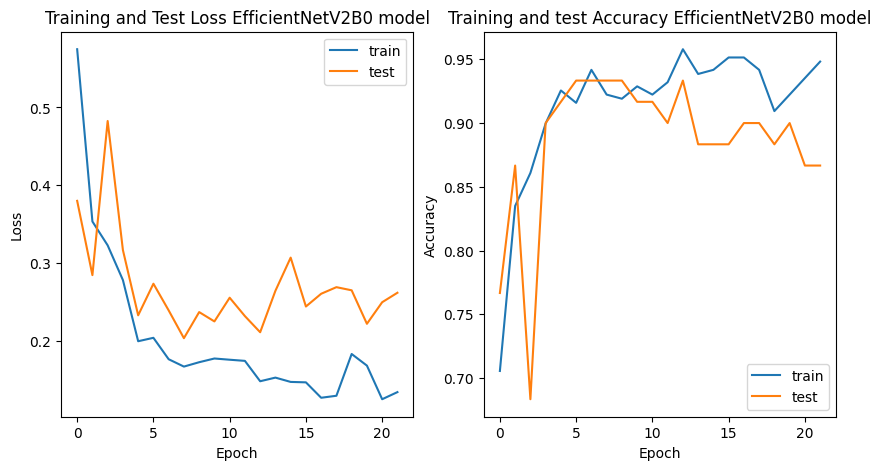

In [ ]:
# Plot the validation and training loss and accuracy values
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(train_val_losses, label='train')
ax[0].plot(test_losses, label='test')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training and Test Loss EfficientNetV2B0 model')
ax[0].legend()
ax[1].plot(train_val_accuracies, label='train')
ax[1].plot(test_accuracies, label='test')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Training and test Accuracy EfficientNetV2B0 model')
ax[1].legend()
plt.show()

## Test performance EfficientNetV2B0 model

In [ ]:
# load in testset
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = ImageFolder(test_path, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

In [ ]:
model.eval()
test_loss = 0.0
y_true = []
y_pred = []
Y_pred_prob = []

with torch.no_grad():
   for i in test_loader:

          #LOAD THE DATA IN A BATCH
          data, target = i

          # moving the tensors to the configured device
          data, target = data.to(DEVICE), target.to(DEVICE)

          target = target.float()
          output = model(data.float())

          loss = criterion(output, target.unsqueeze(1))
          test_loss += loss.item() * data.size(0)


          #PREDICTIONS
          pred_prop = torch.sigmoid(output)
          pred = torch.round(torch.sigmoid(output))

          y_true.extend(target.tolist())
          y_pred.extend(pred.reshape(-1).tolist())
          Y_pred_prob.extend(pred_prop.reshape(-1).tolist())

test_loss /= len(test_loader.sampler)
test_accuracy = accuracy_score(y_true,y_pred)

# get the specificity, sensitivity and g-mean
cm = confusion_matrix(y_true, y_pred)

# Extract the elements of the confusion matrix
tn, fp, fn, tp = cm.ravel()

# Calculate specificity and sensitivity
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

g_mean = imblearn.metrics.geometric_mean_score(y_true, y_pred)


print()
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1score = f1_score(y_true, y_pred)
f1score_macro = f1_score(y_true, y_pred, average = 'macro')
auc_roc = roc_auc_score(y_true, Y_pred_prob)

# Print the evaluation metrics
print('Test_loss:', test_loss)
print('Accuracy:', test_accuracy)
print()

print('Specificity:', specificity)
print('Sensitivity:', sensitivity)
print('g_mean:', g_mean)
print()

print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1score)
print('F1_score_macro:', f1score_macro)
print('AUC-ROC:', auc_roc)
print()

print(classification_report(y_true, y_pred))


Test_loss: 0.26184764405091604
Accuracy: 0.8666666666666667

Specificity: 0.8333333333333334
Sensitivity: 0.8809523809523809
g_mean: 0.8568121054974562

Precision: 0.925
Recall: 0.8809523809523809
F1-score: 0.9024390243902439
F1_score_macro: 0.8459563543003851
AUC-ROC: 0.9444444444444445

              precision    recall  f1-score   support

         0.0       0.75      0.83      0.79        18
         1.0       0.93      0.88      0.90        42

    accuracy                           0.87        60
   macro avg       0.84      0.86      0.85        60
weighted avg       0.87      0.87      0.87        60



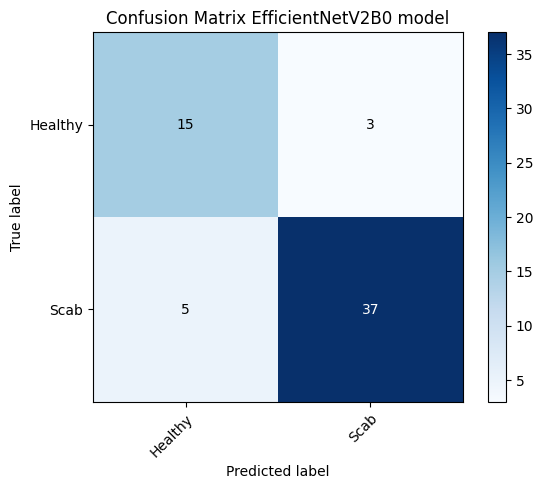

In [ ]:
import matplotlib.pyplot as plt

# Create a confusion matrix:
cm = confusion_matrix(y_true, y_pred)

# Define the class labels
classes = np.unique(['Healthy', 'Scab'])

# Create the plot
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Add axis labels and tick marks
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes,
       yticklabels=classes,
       xlabel='Predicted label',
       ylabel='True label')

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black")

# Add a title and show plot
ax.set_title("Confusion Matrix EfficientNetV2B0 model")
plt.show()

# ConvNeXtTiny model

In [ ]:
timm.list_models('*convnext_tiny*', pretrained=True) # 'convnext_tiny.fb_in1k' (resnet pretrained on imagenet 1k with input size 224x224)

['convnext_tiny.fb_in1k',
 'convnext_tiny.fb_in22k',
 'convnext_tiny.fb_in22k_ft_in1k',
 'convnext_tiny.fb_in22k_ft_in1k_384',
 'convnext_tiny.in12k',
 'convnext_tiny.in12k_ft_in1k',
 'convnext_tiny.in12k_ft_in1k_384',
 'convnext_tiny_hnf.a2h_in1k']

## Do hyperparameter tuning ConvNeXtTiny model

In [ ]:
# Set device and parameters
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCHSIZE = 32
epochs = 100


def define_model(trial):
  model = timm.create_model('convnext_tiny.fb_in1k', pretrained=True, in_chans=3)

  for param in model.parameters():
    param.requires_grad = False

  num_in_features = model.get_classifier().in_features

  head = []
  first_neuron = trial.suggest_categorical('first_neuron', [128, 256, 512, 768])
  head.append(nn.Linear(in_features=num_in_features, out_features=first_neuron))
  head.append(nn.ReLU())
  drop_out = trial.suggest_categorical('drop_out', [0, 0.3, 0.5])
  head.append(nn.Dropout(p=drop_out))
  num_in_features = first_neuron

  head.append(nn.Linear(in_features=num_in_features, out_features=1))

  model.head.fc = nn.Sequential(*head)

  for param in model.head.parameters():
    param.requires_grad = True

  return model


def get_dataset():

  transform_train = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

  transform_valid = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])

  train_dataset = ImageFolder(train_path, transform=transform_train)
  val_dataset = ImageFolder(val_path, transform=transform_valid)

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCHSIZE, shuffle=True)
  valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCHSIZE, shuffle=True)

  return train_loader, valid_loader


def objective(trial):

  # Send model to the device
  model = define_model(trial).to(DEVICE)

  # Define optimizer and loss function
  optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "AdamW"])
  learning_rate = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
  weightdecay = trial.suggest_float("weightdecay", low=0.001, high=0.01, log=True)

  if optimizer_name == 'RMSprop':
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weightdecay)
  elif optimizer_name == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weightdecay)
  elif optimizer_name == 'AdamW':
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weightdecay)


  use_pos_weight = trial.suggest_categorical("use_pos_weight", [True, False])

  if use_pos_weight is True:
    criterion = nn.BCEWithLogitsLoss(pos_weight=train_pos_weight_tensor)
  else:
    criterion = nn.BCEWithLogitsLoss()

  # Load in dataset
  train_loader, valid_loader = get_dataset()

  # Initialize variables for early stopping
  best_loss = 1000000
  patience = 5
  no_improvement_count = 0


  # Training
  for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    y_true = []
    y_pred = []


    for i in train_loader:
        #LOADING THE DATA IN A BATCH
        data, target = i

        # moving the tensors to the configured device
        data, target = data.to(DEVICE), target.to(DEVICE)

        #FORWARD PASS
        target = target.float()
        output = model(data.float())
        loss = criterion(output, target.unsqueeze(1))

        train_loss += loss.item() * data.size(0)

        #BACKWARD AND OPTIMIZE
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        #PREDICTIONS BCELogitsloss()
        pred = torch.round(torch.sigmoid(output.detach()))
        y_true.extend(target.tolist())
        y_pred.extend(pred.reshape(-1).tolist())

    train_loss /= len(train_loader.sampler)
    train_accuracy = accuracy_score(y_true, y_pred)

    cm = confusion_matrix(y_true, y_pred)

    # Extract the elements of the confusion matrix
    tn, fp, fn, tp = cm.ravel()

    # Calculate specificity and sensitivity
    train_specificity = tn / (tn + fp)
    train_sensitivity = tp / (tp + fn)

    train_gmean = imblearn.metrics.geometric_mean_score(y_true, y_pred)


    # Evaluation:

    #model in eval mode skips Dropout etc
    model.eval()
    valid_loss = 0.0
    y_true = []
    y_pred = []

    # set the requires_grad flag to false as we are in the test mode
    with torch.no_grad():
        for i in valid_loader:

            #LOAD THE DATA IN A BATCH
            data, target = i

            # moving the tensors to the configured device
            data, target = data.to(DEVICE), target.to(DEVICE)

            target = target.float()
            output = model(data.float())

            loss = criterion(output, target.unsqueeze(1))
            valid_loss += loss.item() * data.size(0)


            #PREDICTIONS
            pred = torch.round(torch.sigmoid(output))
            y_true.extend(target.tolist())
            y_pred.extend(pred.reshape(-1).tolist())

    valid_loss /= len(valid_loader.sampler)
    valid_accuracy = accuracy_score(y_true,y_pred)

    # get the specificity, sensitivity and g-mean
    cm = confusion_matrix(y_true, y_pred)

    # Extract the elements of the confusion matrix
    tn, fp, fn, tp = cm.ravel()

    # Calculate specificity and sensitivity
    valid_specificity = tn / (tn + fp)
    valid_sensitivity = tp / (tp + fn)

    valid_gmean = imblearn.metrics.geometric_mean_score(y_true, y_pred)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}% "
          f"Train specificity: {train_specificity:.4f}, Train sensitivity: {train_sensitivity:.4f} Train g_mean: {train_gmean:.4f}% ----> "
          f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}% "
          f"Valid specificity: {valid_specificity:.4f}, Valid sensitivity: {valid_sensitivity:.4f} Valid g_mean: {valid_gmean:.4f}")

    # Early stopping
    if valid_loss < best_loss:
        best_loss = valid_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    if no_improvement_count >= patience:
        print("Early stopping criterion met at epoch {}".format(epoch))
        break

    # Pruning
    if trial.should_prune():
        raise optuna.TrialPruned()

    # Report the intermediate result
    trial.report(valid_gmean, epoch)

  return valid_gmean


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=10)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2023-06-13 21:21:57,851] A new study created in memory with name: no-name-29ad02c2-7738-4a62-a0ca-f00c4843a384


Epoch [1/100], Train Loss: 0.6886, Train Accuracy: 0.5517% Train specificity: 0.7870, Train sensitivity: 0.3468 Train g_mean: 0.5224% ----> Valid Loss: 0.6824, Valid Accuracy: 0.6949% Valid specificity: 0.1667, Valid sensitivity: 0.9268 Valid g_mean: 0.3930
Epoch [2/100], Train Loss: 0.6829, Train Accuracy: 0.6121% Train specificity: 0.3611, Train sensitivity: 0.8306 Train g_mean: 0.5477% ----> Valid Loss: 0.6626, Valid Accuracy: 0.6949% Valid specificity: 0.0000, Valid sensitivity: 1.0000 Valid g_mean: 0.0000
Epoch [3/100], Train Loss: 0.6692, Train Accuracy: 0.5948% Train specificity: 0.1944, Train sensitivity: 0.9435 Train g_mean: 0.4283% ----> Valid Loss: 0.6532, Valid Accuracy: 0.6949% Valid specificity: 0.0000, Valid sensitivity: 1.0000 Valid g_mean: 0.0000
Epoch [4/100], Train Loss: 0.6599, Train Accuracy: 0.6724% Train specificity: 0.3704, Train sensitivity: 0.9355 Train g_mean: 0.5886% ----> Valid Loss: 0.6520, Valid Accuracy: 0.7119% Valid specificity: 0.0556, Valid sensitivi

[I 2023-06-13 23:01:09,669] Trial 0 finished with value: 0.8490389912554587 and parameters: {'first_neuron': 256, 'drop_out': 0.5, 'optimizer': 'Adam', 'lr': 0.00016150489641414254, 'weightdecay': 0.004207838692582182, 'use_pos_weight': False}. Best is trial 0 with value: 0.8490389912554587.


Epoch [72/100], Train Loss: 0.2761, Train Accuracy: 0.9095% Train specificity: 0.8889, Train sensitivity: 0.9274 Train g_mean: 0.9079% ----> Valid Loss: 0.4391, Valid Accuracy: 0.8814% Valid specificity: 0.7778, Valid sensitivity: 0.9268 Valid g_mean: 0.8490
Early stopping criterion met at epoch 71
Epoch [1/100], Train Loss: 1.9612, Train Accuracy: 0.5000% Train specificity: 0.5556, Train sensitivity: 0.4516 Train g_mean: 0.5009% ----> Valid Loss: 0.6797, Valid Accuracy: 0.6949% Valid specificity: 0.0000, Valid sensitivity: 1.0000 Valid g_mean: 0.0000
Epoch [2/100], Train Loss: 0.5495, Train Accuracy: 0.7328% Train specificity: 0.7222, Train sensitivity: 0.7419 Train g_mean: 0.7320% ----> Valid Loss: 0.5492, Valid Accuracy: 0.6780% Valid specificity: 0.0000, Valid sensitivity: 0.9756 Valid g_mean: 0.0000
Epoch [3/100], Train Loss: 0.4709, Train Accuracy: 0.7802% Train specificity: 0.7593, Train sensitivity: 0.7984 Train g_mean: 0.7786% ----> Valid Loss: 0.5781, Valid Accuracy: 0.6949% 

[I 2023-06-13 23:17:08,124] Trial 1 finished with value: 0.408248290463863 and parameters: {'first_neuron': 256, 'drop_out': 0, 'optimizer': 'RMSprop', 'lr': 0.004075755130318062, 'weightdecay': 0.002392362748376749, 'use_pos_weight': True}. Best is trial 0 with value: 0.8490389912554587.


Epoch [12/100], Train Loss: 0.3048, Train Accuracy: 0.8793% Train specificity: 0.8519, Train sensitivity: 0.9032 Train g_mean: 0.8772% ----> Valid Loss: 0.5503, Valid Accuracy: 0.7458% Valid specificity: 0.1667, Valid sensitivity: 1.0000 Valid g_mean: 0.4082
Early stopping criterion met at epoch 11
Epoch [1/100], Train Loss: 0.6883, Train Accuracy: 0.5560% Train specificity: 0.7685, Train sensitivity: 0.3710 Train g_mean: 0.5339% ----> Valid Loss: 0.6795, Valid Accuracy: 0.7627% Valid specificity: 0.3889, Valid sensitivity: 0.9268 Valid g_mean: 0.6004
Epoch [2/100], Train Loss: 0.6684, Train Accuracy: 0.6897% Train specificity: 0.3981, Train sensitivity: 0.9435 Train g_mean: 0.6129% ----> Valid Loss: 0.6626, Valid Accuracy: 0.7119% Valid specificity: 0.1111, Valid sensitivity: 0.9756 Valid g_mean: 0.3292
Epoch [3/100], Train Loss: 0.6545, Train Accuracy: 0.6767% Train specificity: 0.3333, Train sensitivity: 0.9758 Train g_mean: 0.5703% ----> Valid Loss: 0.6467, Valid Accuracy: 0.6949% 

[I 2023-06-14 00:01:00,402] Trial 2 finished with value: 0.7851949855364928 and parameters: {'first_neuron': 768, 'drop_out': 0.3, 'optimizer': 'Adam', 'lr': 0.00013752334420179407, 'weightdecay': 0.004196116463562837, 'use_pos_weight': False}. Best is trial 0 with value: 0.8490389912554587.


Epoch [35/100], Train Loss: 0.3207, Train Accuracy: 0.8836% Train specificity: 0.9074, Train sensitivity: 0.8629 Train g_mean: 0.8849% ----> Valid Loss: 0.4729, Valid Accuracy: 0.8136% Valid specificity: 0.7222, Valid sensitivity: 0.8537 Valid g_mean: 0.7852
Early stopping criterion met at epoch 34
Epoch [1/100], Train Loss: 0.6654, Train Accuracy: 0.5431% Train specificity: 0.3333, Train sensitivity: 0.7258 Train g_mean: 0.4919% ----> Valid Loss: 0.5981, Valid Accuracy: 0.7119% Valid specificity: 0.1111, Valid sensitivity: 0.9756 Valid g_mean: 0.3292
Epoch [2/100], Train Loss: 0.5802, Train Accuracy: 0.7371% Train specificity: 0.7130, Train sensitivity: 0.7581 Train g_mean: 0.7352% ----> Valid Loss: 0.5531, Valid Accuracy: 0.7288% Valid specificity: 0.1667, Valid sensitivity: 0.9756 Valid g_mean: 0.4032
Epoch [3/100], Train Loss: 0.5014, Train Accuracy: 0.7716% Train specificity: 0.6759, Train sensitivity: 0.8548 Train g_mean: 0.7601% ----> Valid Loss: 0.6560, Valid Accuracy: 0.5424% 

[I 2023-06-14 00:24:32,023] Trial 3 finished with value: 0.8064778385455118 and parameters: {'first_neuron': 256, 'drop_out': 0.5, 'optimizer': 'AdamW', 'lr': 0.0024577536441942336, 'weightdecay': 0.0017900202985158974, 'use_pos_weight': False}. Best is trial 0 with value: 0.8490389912554587.


Epoch [19/100], Train Loss: 0.1884, Train Accuracy: 0.9310% Train specificity: 0.9537, Train sensitivity: 0.9113 Train g_mean: 0.9323% ----> Valid Loss: 0.3985, Valid Accuracy: 0.8814% Valid specificity: 0.6667, Valid sensitivity: 0.9756 Valid g_mean: 0.8065
Early stopping criterion met at epoch 18
Epoch [1/100], Train Loss: 0.6705, Train Accuracy: 0.5862% Train specificity: 0.4815, Train sensitivity: 0.6774 Train g_mean: 0.5711% ----> Valid Loss: 0.6227, Valid Accuracy: 0.7458% Valid specificity: 0.1667, Valid sensitivity: 1.0000 Valid g_mean: 0.4082
Epoch [2/100], Train Loss: 0.5901, Train Accuracy: 0.7457% Train specificity: 0.6111, Train sensitivity: 0.8629 Train g_mean: 0.7262% ----> Valid Loss: 0.5875, Valid Accuracy: 0.7458% Valid specificity: 0.3333, Valid sensitivity: 0.9268 Valid g_mean: 0.5558
Epoch [3/100], Train Loss: 0.5252, Train Accuracy: 0.8060% Train specificity: 0.7500, Train sensitivity: 0.8548 Train g_mean: 0.8007% ----> Valid Loss: 0.5455, Valid Accuracy: 0.7627% 

[I 2023-06-14 00:54:41,516] Trial 4 finished with value: 0.8181544437127611 and parameters: {'first_neuron': 256, 'drop_out': 0, 'optimizer': 'AdamW', 'lr': 0.0010103144216638603, 'weightdecay': 0.003817979947782679, 'use_pos_weight': False}. Best is trial 0 with value: 0.8490389912554587.


Epoch [23/100], Train Loss: 0.1359, Train Accuracy: 0.9483% Train specificity: 0.9444, Train sensitivity: 0.9516 Train g_mean: 0.9480% ----> Valid Loss: 0.4116, Valid Accuracy: 0.8644% Valid specificity: 0.7222, Valid sensitivity: 0.9268 Valid g_mean: 0.8182
Early stopping criterion met at epoch 22
Epoch [1/100], Train Loss: 0.6615, Train Accuracy: 0.6078% Train specificity: 0.4352, Train sensitivity: 0.7581 Train g_mean: 0.5744% ----> Valid Loss: 0.7148, Valid Accuracy: 0.4237% Valid specificity: 0.8333, Valid sensitivity: 0.2439 Valid g_mean: 0.4508
Epoch [2/100], Train Loss: 0.5862, Train Accuracy: 0.6595% Train specificity: 0.4907, Train sensitivity: 0.8065 Train g_mean: 0.6291% ----> Valid Loss: 0.6640, Valid Accuracy: 0.4915% Valid specificity: 0.7778, Valid sensitivity: 0.3659 Valid g_mean: 0.5334
Epoch [3/100], Train Loss: 0.4909, Train Accuracy: 0.7716% Train specificity: 0.7963, Train sensitivity: 0.7500 Train g_mean: 0.7728% ----> Valid Loss: 0.5085, Valid Accuracy: 0.7966% 

[I 2023-06-14 01:10:04,369] Trial 5 finished with value: 0.7269492998503029 and parameters: {'first_neuron': 128, 'drop_out': 0.5, 'optimizer': 'AdamW', 'lr': 0.005184923462586391, 'weightdecay': 0.003992853771647933, 'use_pos_weight': False}. Best is trial 0 with value: 0.8490389912554587.


Epoch [12/100], Train Loss: 0.1818, Train Accuracy: 0.9353% Train specificity: 0.9630, Train sensitivity: 0.9113 Train g_mean: 0.9368% ----> Valid Loss: 0.4486, Valid Accuracy: 0.8305% Valid specificity: 0.5556, Valid sensitivity: 0.9512 Valid g_mean: 0.7269
Early stopping criterion met at epoch 11
Epoch [1/100], Train Loss: 0.6117, Train Accuracy: 0.6336% Train specificity: 0.7222, Train sensitivity: 0.5565 Train g_mean: 0.6339% ----> Valid Loss: 0.5556, Valid Accuracy: 0.6780% Valid specificity: 0.0556, Valid sensitivity: 0.9512 Valid g_mean: 0.2299


[I 2023-06-14 01:12:39,490] Trial 6 pruned. 


Epoch [2/100], Train Loss: 0.5203, Train Accuracy: 0.7672% Train specificity: 0.7037, Train sensitivity: 0.8226 Train g_mean: 0.7608% ----> Valid Loss: 0.5591, Valid Accuracy: 0.6949% Valid specificity: 0.7222, Valid sensitivity: 0.6829 Valid g_mean: 0.7023
Epoch [1/100], Train Loss: 0.7051, Train Accuracy: 0.5690% Train specificity: 0.4722, Train sensitivity: 0.6532 Train g_mean: 0.5554% ----> Valid Loss: 0.8167, Valid Accuracy: 0.3051% Valid specificity: 0.9444, Valid sensitivity: 0.0244 Valid g_mean: 0.1518


[I 2023-06-14 01:15:09,136] Trial 7 pruned. 


Epoch [2/100], Train Loss: 0.6048, Train Accuracy: 0.7026% Train specificity: 0.6481, Train sensitivity: 0.7500 Train g_mean: 0.6972% ----> Valid Loss: 0.6112, Valid Accuracy: 0.7288% Valid specificity: 0.6111, Valid sensitivity: 0.7805 Valid g_mean: 0.6906
Epoch [1/100], Train Loss: 0.7219, Train Accuracy: 0.5129% Train specificity: 0.5093, Train sensitivity: 0.5161 Train g_mean: 0.5127% ----> Valid Loss: 0.7110, Valid Accuracy: 0.4407% Valid specificity: 0.8333, Valid sensitivity: 0.2683 Valid g_mean: 0.4728
Epoch [2/100], Train Loss: 0.6103, Train Accuracy: 0.7198% Train specificity: 0.6296, Train sensitivity: 0.7984 Train g_mean: 0.7090% ----> Valid Loss: 0.5667, Valid Accuracy: 0.6949% Valid specificity: 0.0000, Valid sensitivity: 1.0000 Valid g_mean: 0.0000
Epoch [3/100], Train Loss: 0.5326, Train Accuracy: 0.7802% Train specificity: 0.6296, Train sensitivity: 0.9113 Train g_mean: 0.7575% ----> Valid Loss: 0.5870, Valid Accuracy: 0.7288% Valid specificity: 0.7778, Valid sensitivi

[I 2023-06-14 01:43:01,324] Trial 8 finished with value: 0.8329267300725657 and parameters: {'first_neuron': 128, 'drop_out': 0.3, 'optimizer': 'AdamW', 'lr': 0.005394918697102136, 'weightdecay': 0.008364420435461142, 'use_pos_weight': False}. Best is trial 0 with value: 0.8490389912554587.


Epoch [21/100], Train Loss: 0.1151, Train Accuracy: 0.9698% Train specificity: 0.9630, Train sensitivity: 0.9758 Train g_mean: 0.9694% ----> Valid Loss: 0.4059, Valid Accuracy: 0.8136% Valid specificity: 0.8889, Valid sensitivity: 0.7805 Valid g_mean: 0.8329
Early stopping criterion met at epoch 20
Epoch [1/100], Train Loss: 0.7089, Train Accuracy: 0.5776% Train specificity: 0.4815, Train sensitivity: 0.6613 Train g_mean: 0.5643% ----> Valid Loss: 0.6005, Valid Accuracy: 0.6949% Valid specificity: 0.1111, Valid sensitivity: 0.9512 Valid g_mean: 0.3251


[I 2023-06-14 01:45:32,836] Trial 9 pruned. 


Epoch [2/100], Train Loss: 0.5632, Train Accuracy: 0.7586% Train specificity: 0.6852, Train sensitivity: 0.8226 Train g_mean: 0.7507% ----> Valid Loss: 0.6590, Valid Accuracy: 0.5932% Valid specificity: 0.7778, Valid sensitivity: 0.5122 Valid g_mean: 0.6312
Study statistics: 
  Number of finished trials:  10
  Number of pruned trials:  3
  Number of complete trials:  7
Best trial:
  Value:  0.8490389912554587
  Params: 
    first_neuron: 256
    drop_out: 0.5
    optimizer: Adam
    lr: 0.00016150489641414254
    weightdecay: 0.004207838692582182
    use_pos_weight: False


In [ ]:
trials_df = study.trials_dataframe()
trials_df

,number,value,datetime_start,datetime_complete,duration,params_drop_out,params_first_neuron,params_lr,params_optimizer,params_use_pos_weight,params_weightdecay,state
0,0,0.849039,2023-06-13 21:21:57.853498,2023-06-13 23:01:09.668231,0 days 01:39:11.814733,0.5,256,0.000162,Adam,False,0.004208,COMPLETE
1,1,0.408248,2023-06-13 23:01:09.671524,2023-06-13 23:17:08.124323,0 days 00:15:58.452799,0.0,256,0.004076,RMSprop,True,0.002392,COMPLETE
2,2,0.785195,2023-06-13 23:17:08.126083,2023-06-14 00:01:00.402350,0 days 00:43:52.276267,0.3,768,0.000138,Adam,False,0.004196,COMPLETE
3,3,0.806478,2023-06-14 00:01:00.403932,2023-06-14 00:24:32.023208,0 days 00:23:31.619276,0.5,256,0.002458,AdamW,False,0.001790,COMPLETE
4,4,0.818154,2023-06-14 00:24:32.024788,2023-06-14 00:54:41.515815,0 days 00:30:09.491027,0.0,256,0.001010,AdamW,False,0.003818,COMPLETE
5,5,0.726949,2023-06-14 00:54:41.517383,2023-06-14 01:10:04.368678,0 days 00:15:22.851295,0.5,128,0.005185,AdamW,False,0.003993,COMPLETE
6,6,0.229882,2023-06-14 01:10:04.370260,2023-06-14 01:12:39.490039,0 days 00:02:35.119779,0.0,512,0.000908,Adam,True,0.001673,PRUNED
7,7,0.151774,2023-06-14 01:12:39.491570,2023-06-14 01:15:09.136479,0 days 00:02:29.644909,0.0,256,0.000662,RMSprop,False,0.007843,PRUNED
8,8,0.832927,2023-06-14 01:15:09.138082,2023-06-14 01:43:01.324327,0 days 00:27:52.186245,0.3,128,0.005395,AdamW,False,0.008364,COMPLETE
9,9,0.325102,2023-06-14 01:43:01.325982,2023-06-14 01:45:32.835972,0 days 00:02:31.509990,0.5,512,0.000552,RMSprop,False,0.007423,PRUNED


In [ ]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

## Train the ConvNeXtTiny model with the best hyperparameters (on combined training and validation dataset)

In [ ]:
BATCHSIZE = 32
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

best_neurons = 256
best_dropout = 0.5
best_optimizer = 'Adam'
best_lr = 0.000162
epochs = 72
weight_decay = 0.004208
use_pos_weight = False


def define_model():
  model = timm.create_model('convnext_tiny.fb_in1k', pretrained=True, in_chans=3)

  for param in model.parameters():
    param.requires_grad = False

  num_in_features = model.get_classifier().in_features

  head = []
  head.append(nn.Linear(in_features=num_in_features, out_features=best_neurons))
  head.append(nn.ReLU())
  head.append(nn.Dropout(p=best_dropout))
  num_in_features = best_neurons

  head.append(nn.Linear(in_features=num_in_features, out_features=1))

  model.head.fc = nn.Sequential(*head)

  for param in model.head.parameters():
    param.requires_grad = True

  return model


def get_dataset():

  transform_train = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

  transform_valid = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])

  train_val_dataset = ImageFolder(train_val_path, transform=transform_train)
  test_dataset = ImageFolder(test_path, transform=transform_valid) # Test dataset only used to see learning curve (no hp tuning)

  train_val_loader = torch.utils.data.DataLoader(train_val_dataset, batch_size=BATCHSIZE, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCHSIZE, shuffle=False)

  return train_val_loader, test_loader


# Send model to the device
model = define_model().to(DEVICE)

# Define optimizer and loss function
if best_optimizer == 'RMSprop':
  optimizer = torch.optim.RMSprop(model.parameters(), lr=best_lr, weight_decay=weight_decay)
elif best_optimizer == 'Adam':
  optimizer = torch.optim.Adam(model.parameters(), lr=best_lr, weight_decay=weight_decay)
elif best_optimizer == 'AdamW':
  optimizer = torch.optim.AdamW(model.parameters(), lr=best_lr, weight_decay=weight_decay)

if use_pos_weight is True:
  criterion = nn.BCEWithLogitsLoss(pos_weight=train_pos_weight_tensor)
else:
  criterion = nn.BCEWithLogitsLoss()

# Load in dataset
train_val_loader, test_loader = get_dataset()

# Initialize variables for early stopping
best_loss = 1000000
patience = 5
no_improvement_count = 0

# train_val
train_val_losses = []
train_val_accuracies = []
test_losses = []
test_accuracies = []

# Training
for epoch in range(epochs):
  model.train()
  train_val_loss = 0.0
  y_true = []
  y_pred = []


  for i in train_val_loader:
      #LOADING THE DATA IN A BATCH
      data, target = i

      # moving the tensors to the configured device
      data, target = data.to(DEVICE), target.to(DEVICE)

      #FORWARD PASS
      target = target.float()
      output = model(data.float())
      loss = criterion(output, target.unsqueeze(1))

      train_val_loss += loss.item() * data.size(0)

      #BACKWARD AND OPTIMIZE
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


      #PREDICTIONS BCELogitsloss()
      pred = torch.round(torch.sigmoid(output.detach()))
      y_true.extend(target.tolist())
      y_pred.extend(pred.reshape(-1).tolist())

  train_val_loss /= len(train_val_loader.sampler)
  train_val_accuracy = accuracy_score(y_true, y_pred)

  train_val_losses.append(train_val_loss)
  train_val_accuracies.append(train_val_accuracy)

  cm = confusion_matrix(y_true, y_pred)

  # Extract the elements of the confusion matrix
  tn, fp, fn, tp = cm.ravel()

  # Calculate specificity and sensitivity
  train_val_specificity = tn / (tn + fp)
  train_val_sensitivity = tp / (tp + fn)

  train_val_gmean = imblearn.metrics.geometric_mean_score(y_true, y_pred)

  # Evaluation:

   #model in eval mode skips Dropout etc
  model.eval()
  test_loss = 0.0
  y_true = []
  y_pred = []

  # set the requires_grad flag to false as we are in the test mode
  with torch.no_grad():
      for i in test_loader:

          #LOAD THE DATA IN A BATCH
          data, target = i

          # moving the tensors to the configured device
          data, target = data.to(DEVICE), target.to(DEVICE)

          target = target.float()
          output = model(data.float())

          loss = criterion(output, target.unsqueeze(1))
          test_loss += loss.item() * data.size(0)


          #PREDICTIONS
          pred = torch.round(torch.sigmoid(output))
          y_true.extend(target.tolist())
          y_pred.extend(pred.reshape(-1).tolist())

  test_loss /= len(test_loader.sampler)
  test_accuracy = accuracy_score(y_true, y_pred)

  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)

  # get the specificity, sensitivity and g-mean
  cm = confusion_matrix(y_true, y_pred)

  # Extract the elements of the confusion matrix
  tn, fp, fn, tp = cm.ravel()

  # Calculate specificity and sensitivity
  test_specificity = tn / (tn + fp)
  test_sensitivity = tp / (tp + fn)

  test_gmean = imblearn.metrics.geometric_mean_score(y_true, y_pred)

  print(f"Epoch [{epoch+1}/{epochs}], Train_val Loss: {train_val_loss:.4f}, Train_val Accuracy: {train_val_accuracy:.4f}%, "
        f"Train_val specificity: {train_val_specificity:.4f}, Train_val sensitivity: {train_val_sensitivity:.4f}, Train_val g_mean: {train_val_gmean:.4f}% ----> "
        f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}%, "
        f"Test specificity: {test_specificity:.4f}, Test sensitivity: {test_sensitivity:.4f}, Test g_mean: {test_gmean:.4f}")

Epoch [1/72], Train_val Loss: 0.6889, Train_val Accuracy: 0.5761%, Train_val specificity: 0.5208, Train_val sensitivity: 0.6242, Train_val g_mean: 0.5702% ----> Test Loss: 0.6724, Test Accuracy: 0.7000%, Test specificity: 0.0000, Test sensitivity: 1.0000, Test g_mean: 0.0000
Epoch [2/72], Train_val Loss: 0.6746, Train_val Accuracy: 0.6052%, Train_val specificity: 0.3472, Train_val sensitivity: 0.8303, Train_val g_mean: 0.5369% ----> Test Loss: 0.6499, Test Accuracy: 0.7000%, Test specificity: 0.0000, Test sensitivity: 1.0000, Test g_mean: 0.0000
Epoch [3/72], Train_val Loss: 0.6653, Train_val Accuracy: 0.6408%, Train_val specificity: 0.3125, Train_val sensitivity: 0.9273, Train_val g_mean: 0.5383% ----> Test Loss: 0.6357, Test Accuracy: 0.7333%, Test specificity: 0.1111, Test sensitivity: 1.0000, Test g_mean: 0.3333
Epoch [4/72], Train_val Loss: 0.6546, Train_val Accuracy: 0.6828%, Train_val specificity: 0.4583, Train_val sensitivity: 0.8788, Train_val g_mean: 0.6346% ----> Test Loss: 

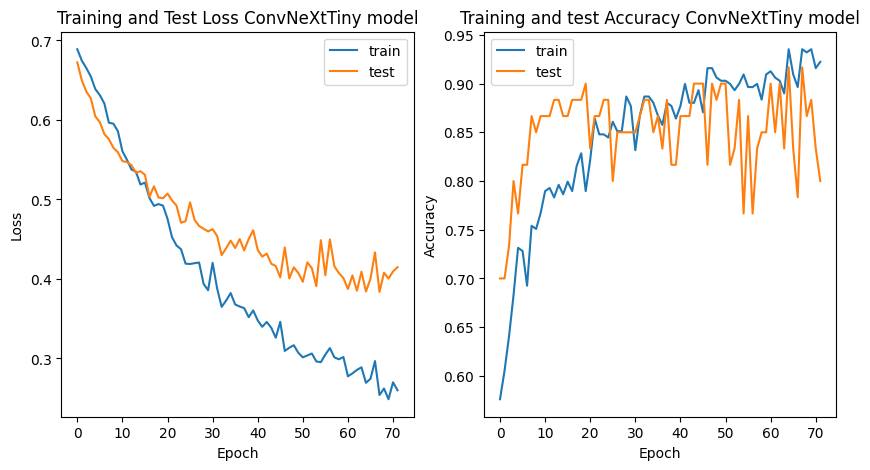

In [ ]:
# Plot the validation and training loss and accuracy values
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(train_val_losses, label='train')
ax[0].plot(test_losses, label='test')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training and Test Loss ConvNeXtTiny model')
ax[0].legend()
ax[1].plot(train_val_accuracies, label='train')
ax[1].plot(test_accuracies, label='test')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Training and test Accuracy ConvNeXtTiny model')
ax[1].legend()
plt.show()

## Test performance ConvNeXtTiny model

In [ ]:
# load in testset
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = ImageFolder(test_path, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

In [ ]:
model.eval()
test_loss = 0.0
y_true = []
y_pred = []
Y_pred_prob = []

with torch.no_grad():
   for i in test_loader:

          #LOAD THE DATA IN A BATCH
          data, target = i

          # moving the tensors to the configured device
          data, target = data.to(DEVICE), target.to(DEVICE)

          target = target.float()
          output = model(data.float())

          loss = criterion(output, target.unsqueeze(1))
          test_loss += loss.item() * data.size(0)


          #PREDICTIONS
          pred_prop = torch.sigmoid(output)
          pred = torch.round(torch.sigmoid(output))

          y_true.extend(target.tolist())
          y_pred.extend(pred.reshape(-1).tolist())
          Y_pred_prob.extend(pred_prop.reshape(-1).tolist())

test_loss /= len(test_loader.sampler)
test_accuracy = accuracy_score(y_true,y_pred)

# get the specificity, sensitivity and g-mean
cm = confusion_matrix(y_true, y_pred)

# Extract the elements of the confusion matrix
tn, fp, fn, tp = cm.ravel()

# Calculate specificity and sensitivity
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

g_mean = imblearn.metrics.geometric_mean_score(y_true, y_pred)


print()
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1score = f1_score(y_true, y_pred)
f1score_macro = f1_score(y_true, y_pred, average = 'macro')
auc_roc = roc_auc_score(y_true, Y_pred_prob)

# Print the evaluation metrics
print('Test_loss:', test_loss)
print('Accuracy:', test_accuracy)
print()

print('Specificity:', specificity)
print('Sensitivity:', sensitivity)
print('g_mean:', g_mean)
print()

print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1score)
print('F1_score_macro:', f1score_macro)
print('AUC-ROC:', auc_roc)
print()

print(classification_report(y_true, y_pred))


Test_loss: 0.41477498412132263
Accuracy: 0.8

Specificity: 0.8333333333333334
Sensitivity: 0.7857142857142857
g_mean: 0.809173593712687

Precision: 0.9166666666666666
Recall: 0.7857142857142857
F1-score: 0.8461538461538461
F1_score_macro: 0.7802197802197802
AUC-ROC: 0.8915343915343916

              precision    recall  f1-score   support

         0.0       0.62      0.83      0.71        18
         1.0       0.92      0.79      0.85        42

    accuracy                           0.80        60
   macro avg       0.77      0.81      0.78        60
weighted avg       0.83      0.80      0.81        60



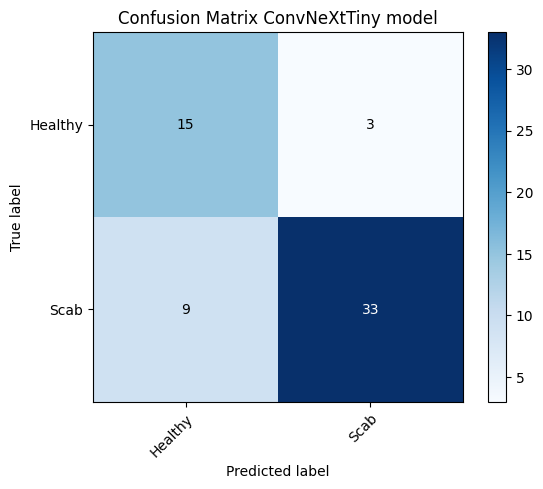

In [ ]:
import matplotlib.pyplot as plt

# Create a confusion matrix:
cm = confusion_matrix(y_true, y_pred)

# Define the class labels
classes = np.unique(['Healthy', 'Scab'])

# Create the plot
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Add axis labels and tick marks
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes,
       yticklabels=classes,
       xlabel='Predicted label',
       ylabel='True label')

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black")

# Add a title and show plot
ax.set_title("Confusion Matrix ConvNeXtTiny model")
plt.show()